In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
from arch import arch_model

C:\Users\Come5\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Come5\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\Come5\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


<h1><p style="text-align: center;">Modélisation de la volatilité</p></h1>



**Introduction**

<br>
<br>
<div style="text-align:justify;">
Depuis que les marchés financiers existent, ils ont été secoués par de nombreuses crises, dont les conséquences ont été dévastatrices pour les économies et les sociétés du monde entier. Le commerce international a intensifié l'intgration des pays entre eux, ce qui a augmenté le risque de propagation des crises mais également démultiplié ses sources.
</div>  

<p>Dans le présent notebook, nous nous intéresserons aux risques de marchés et plus particulièrement la volatilité.</p>


<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">    
<b>Objectifs :</b><br><br> 
- Rappel des faits stylisés qui gouvernent les principaux actifs financiers<br>
- Etude des grandes méthodes de modélisation de la volatilité<br><br>   
<b>A l'issue de ces travaux vous aurez acquis les compétences suivantes :</b><br><br>
- Estimer la volatilité d'actifs financiers<br>
- Estimer des matrices de covariance/corrélation<br>
- Faire des prévisions<br>
- Manipuler des modules statistiques<br>
</p>

**Plan du notebook**
<br>
<br>

<u><b><a href='#stylized_facts'>I. Faits stylisés des rendements</a></b></u>
1. <a href='#return_calculus'>Calcul des rendements</a>
2. <a href='#historical_volatility'>Estimation de la volatilité</a>
3. <a href='#volatility_clusters'>Les clusters de volatilité</a>
4. <a href='#leptokurtic_distribution'>Distribution leptokurtique</a>
5. <a href='#nonlinear_dependance'>La dépendance non linéaire</a>

<u><b><a href='#univariate_model'>II. Modélisation univariée</a></b></u>
1. <a href='#moving_average'>Moving Average</a>
2. <a href='#ewma'>Exponentially Weighted Moving Average (EWMA)</a>
3. <a href='#garch'>ARCH et GARCH</a>
4. <a href='#gjr-garch'>GJR-GARCH</a>

<u><b><a href='#multivariate_model'>III. Modélisation multivariée</a></b></u>
1. <a href='#ccc_model'>Constant Conditional Correlations (CCC)</a>
2. <a href='#dcc_model'>Dynamic Conditional Correlations (DCC)</a>
    
***
*Les lecteurs pourront retrouver une liste exhaustive des grandes crises financières* [ici](https://fr.wikipedia.org/wiki/Liste_des_crises_mon%C3%A9taires_et_financi%C3%A8res).

**Extraction des données**

In [2]:
MY_PATH = "C:\\Users\\Come5\\SynoCome\\AVerley\\PRIVATE\\NoteBook\\equity_index.xlsx"
prices = pd.read_excel(MY_PATH, header=0, index_col=0, parse_dates=True)

Graphique de nos données

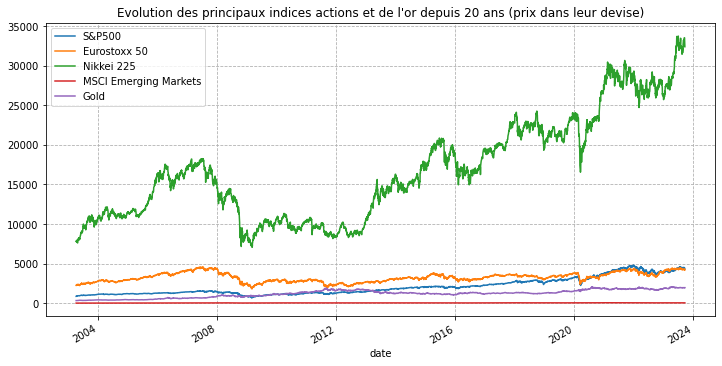

In [3]:
prices.plot(figsize=(12,6))
plt.legend(["S&P500","Eurostoxx 50","Nikkei 225","MSCI Emerging Markets","Gold"])
plt.title("Evolution des principaux indices actions et de l'or depuis 20 ans (prix dans leur devise)")
plt.grid(linestyle="--")
plt.show()

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black"> 
&#x2614;
On voit bien que comparer des indices exprimés en prix n'apporte aucune information. La différence de niveaux entre eux va 'gommer' beaucoup d'informations.
</p>

In [4]:
def rebased_data(data, from_date = None):
    if isinstance(data, pd.DataFrame):
        if not from_date:
            return data.div(data.iloc[0].values) * 100.
        if from_date in data.index:
            return data[data.index >= from_date].div(data[data.index == from_date].values) * 100.
        else:
            print("Given date doesn't exists in the index")
            return None

In [5]:
rebased_index = rebased_data(prices)

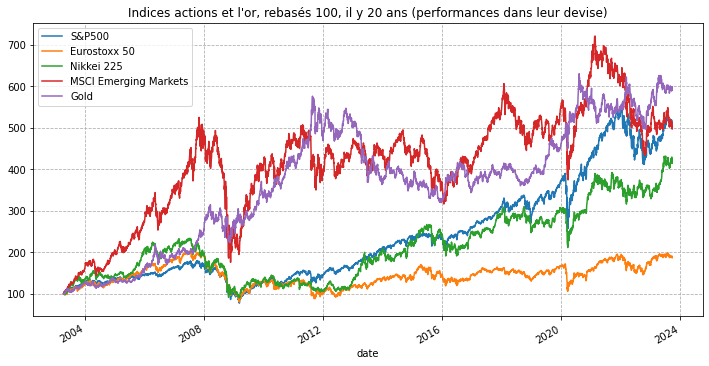

In [6]:
rebased_index.plot(figsize=(12,6))
plt.legend(["S&P500","Eurostoxx 50","Nikkei 225","MSCI Emerging Markets","Gold"])
plt.title("Indices actions et l'or, rebasés 100, il y 20 ans (performances dans leur devise)")
plt.grid(linestyle="--")
plt.show()

<u><b><a id='stylized_facts'>I. Faits stylisés des rendements</a></b></u>

1. <a id='return_calculus'>Calcul des rendements</a>

**Le rendement simple**

$R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}}-1$

In [7]:
simple_returns = prices["GSPC.INDX"].pct_change()

Ci-dessous, la série temporelle des rendements journaliers du Nasdaq (seulement les 5 derniers jours de notre série).

In [8]:
print(simple_returns.tail(5))

date
2023-09-18    0.000721
2023-09-19   -0.002151
2023-09-20   -0.009395
2023-09-21   -0.016401
2023-09-22   -0.002296
Name: GSPC.INDX, dtype: float64


<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black"> 
Veuillez noter que la méthode pct_change() effectue par défaut la différence ligne à ligne tout au long d'un dataframe. Cependant il est possible de changer le paramètre <b>'periods'</b> pour estimer le rendement entre plusieurs jours !

Bien sûr il existe d'autres méthodes permettant de calculer les rendements, nous aurions très bien créer notre fonction :
</p>

In [9]:
def simple_return_calculation(df_prices):
    my_returns = df_prices.divide(df_prices.shift(1)) - 1.
    return my_returns    

Ici aussi on print les 5 derniers rendements. Naturellement, nous obtenons les mêmes résultats que précédement.

In [10]:
my_simple_returns = simple_return_calculation(prices["GSPC.INDX"])
print(my_simple_returns.tail(5))

date
2023-09-18    0.000721
2023-09-19   -0.002151
2023-09-20   -0.009395
2023-09-21   -0.016401
2023-09-22   -0.002296
Name: GSPC.INDX, dtype: float64


Ci-dessous, une nouvelle fonction pour faire exactement la même chose :

In [11]:
def simple_return_calculation_bis(df_prices):
    my_returns = df_prices.iloc[1:] / df_prices.iloc[0:-1].values - 1. 
    return my_returns

Renvoyant bien sûr les mêmes résultats.

In [12]:
my_simple_returns2 = simple_return_calculation_bis(prices["GSPC.INDX"])
print(my_simple_returns2.tail(5))

date
2023-09-18    0.000721
2023-09-19   -0.002151
2023-09-20   -0.009395
2023-09-21   -0.016401
2023-09-22   -0.002296
Name: GSPC.INDX, dtype: float64


<div style="text-align:justify;">
Un des inconvénients du rendement simple est que si l'on souhaite calculer le rendement sur une plus grande période à partir des rendements intermédiaires, les calculs sont plus complexes, car on ne peut pas simplement faire la somme des rendements intermédiaires. La méthode correcte est la suivante :
</div>

$R_t(n) = (1+R_t)(1+R_{t-1})(1+R_{t-2})...(1+R_{t-n})-1$

$=\frac{P_t}{P_{t-1}}\frac{P_{t-1}}{P_{t-2}}...\frac{P_{t-n+1}}{P_{t-n}} - 1 = \frac{P_{t}}{P_{t-n}} - 1$


<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black"> 
&#x2614;
La simple somme des rendements intermédiaires ne permettrait pas de prendre en compte l'intérêt composé !
</p>

In [13]:
def multi_periods_simple_return(prices, start_date, end_date):
    daily_returns = prices[(prices.index >= start_date) & (prices.index <= end_date)].pct_change()
    cumulative_product = (1 + daily_returns).cumprod()
    return cumulative_product.tail(1) - 1

**Exemple**

In [14]:
start_dt = "2023-01-25"
end_dt = "2023-01-31"

return_from_daily_simple_returns = multi_periods_simple_return(prices["GSPC.INDX"], start_dt, end_dt) # Cette methode utilise les rendements
return_from_prices = prices["GSPC.INDX"][prices.index == end_dt].values / prices["GSPC.INDX"][prices.index == start_dt].values - 1. # Cette méthode utilise les prix

print(f"Rendement en utilisant les produits cumulés des rendements journaliers entre deux dates : {return_from_daily_simple_returns[0]:.2%}")
print(f"Rendement en calculant le rendement simple entre deux dates : {return_from_prices[0]:.2%}")

Rendement en utilisant les produits cumulés des rendements journaliers entre deux dates : 1.50%
Rendement en calculant le rendement simple entre deux dates : 1.50%


**Le rendement composé**

$Y_t = log(1 + R_t) = log(\frac{P_t}{P_{t-1}}) = log P_t - log P_{t-1}$

In [15]:
def logarithmic_return_calculation(df_prices):
    return np.log(df_prices).diff()
    
my_log_returns = logarithmic_return_calculation(prices["GSPC.INDX"])    
print(my_log_returns.tail(5))

date
2023-09-18    0.000721
2023-09-19   -0.002153
2023-09-20   -0.009439
2023-09-21   -0.016537
2023-09-22   -0.002298
Name: GSPC.INDX, dtype: float64


<div style="text-align:justify;">
Comme on peut le voir ici, les rendements issus de cette méthode sont différents de ceux obtenus par la méthode des rendements simples. Par contre, avec cette méthode, il est beaucoup plus simple de calculer le rendement entre deux dates à partir des rendements intermédiaires :
</div>
    
$Y_t(n) = log(1+R_t(n))=log((1+R_{t})(1+R_{t-1})(1+R_{t-2})...(1+R_{t-n+1}))$

$=log(1+R_t)+log(1+R_{t-1})+...+log(1+R_{t-n+1})$

$=Y_t+Y_{t-1}+...+Y_{t-n+1}$


<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black"> 
&#129504;
Ces équations nous permettent de voir que le rendement entre deux dates peut s'obtenir en faisant la somme des rendements intermédiaires !
</p>

C'est ce que nous allons vérifier ci-dessous :

In [16]:
def multi_periods_log_return(prices, start_date, end_date):
    daily_returns = np.log(prices[(prices.index >= start_date) & (prices.index <= end_date)]).diff()
    return daily_returns.sum()

In [17]:
return_from_daily_log_returns = multi_periods_log_return(prices["GSPC.INDX"], start_dt, end_dt) # Cette methode utilise les rendements
return_from_prices_log = np.log(prices["GSPC.INDX"][prices.index == end_dt].values) - np.log(prices["GSPC.INDX"][prices.index == start_dt].values) # Cette méthode utilise les prix

print(f"Rendement en utilisant la somme rendements composés journaliers entre deux dates : {return_from_daily_log_returns:.2%}")
print(f"Rendement en calculant le rendement simple entre deux dates : {return_from_prices_log[0]:.2%}")

Rendement en utilisant la somme rendements composés journaliers entre deux dates : 1.49%
Rendement en calculant le rendement simple entre deux dates : 1.49%


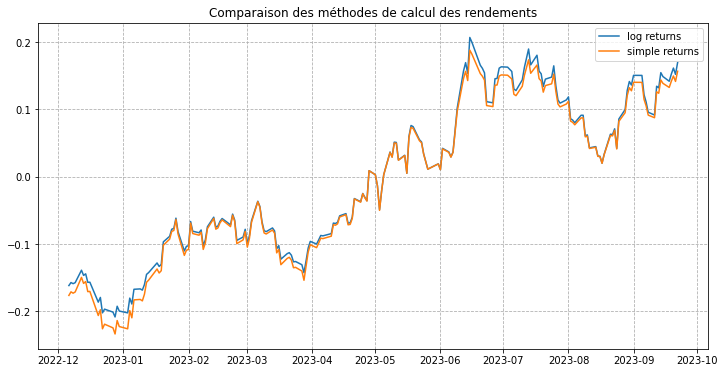

In [18]:
daily_log_returns = prices["GSPC.INDX"].pct_change(250)
daily_simple_returns = np.log(prices["GSPC.INDX"]).diff(250)

plt.figure(figsize=(12,6))
plt.plot(daily_log_returns.tail(200), label="log returns")
plt.plot(daily_simple_returns.tail(200), label="simple returns")
plt.title("Comparaison des méthodes de calcul des rendements")
plt.grid(linestyle="--")
plt.legend()
plt.show()

Ce graphique confirme les chiffres que nous avons obtenu plus haut. Ces méthodes produisent des résultats proches mais différents (marginalement), ce qui peut avoir des impacts sur les études statistiques.

2. <a id='historical_volatility'>Estimation de la volatilité</a>

<div style="text-align:justify;">

Pour étudier ce phénomène, il faut faire la distinction entre la volatilité **conditionnelle** et la volatilité **inconditionnelle** :


- La volatilité inconditionnelle est la volatilité historique, estimée *ex-post* sur les rendements passés des actifs financiers. Elle se mesure avec l'écart-type des rendements et est exprimée en pourcentage, le plus souvent "annualisée".
- La volatilité conditionnelle est la part de la volatilité qui est sensible à différents facteurs. Elle est estimée statistiquement en utilisant toute l'information disponible, et elle permet donc de 'profiler' la volatilité et de faire des prévisions. 
</div>

**Volatilités historiques issues des rendements journalièrs sur toute la période**

In [19]:
prices.pct_change().std()

GSPC.INDX    0.011984
SX5E.INDX    0.013424
N225.INDX    0.014078
EEM.US       0.017769
GC.COMM      0.011160
dtype: float64

**Volatilités historiques calculées sur une fenêtre roulante**


<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black"> 
&#x1F447;
Pour executer la fonction *rolling_volatility* ci-dessous, il est nécessaire de charger en mémoire la fonction qui se trouve plus bas (II. Modélisation univariée 1. <a href='#moving_average'>Moving Average</a>).
</p>

In [22]:
roll_vol = rolling_volatility(prices, 250)

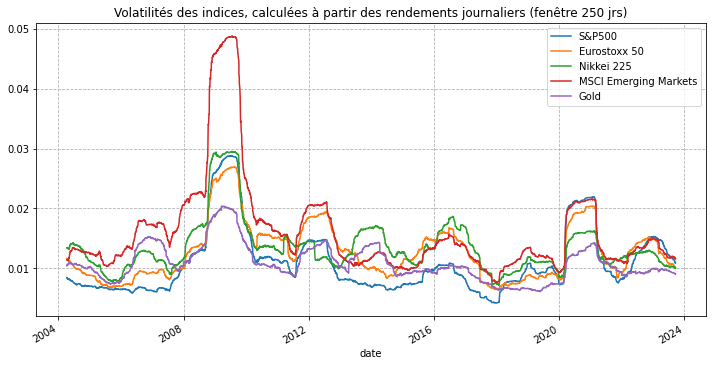

In [23]:
roll_vol.plot(figsize=(12,6))
plt.legend(["S&P500","Eurostoxx 50","Nikkei 225","MSCI Emerging Markets","Gold"])
plt.title("Volatilités des indices, calculées à partir des rendements journaliers (fenêtre 250 jrs)")
plt.grid(linestyle="--")
plt.show()


<div style="text-align:justify;">
&#129504;
Ici les résultats ne sont pas annualisés. Pour cela, il aurait fallu multiplier les volatilités issues des rendements journaliers par la racine de 252 (car 252 jours ouvrés dans une année). Sur d'autres fréquences, il aurait fallu utiliser un autre facteur d'annualisation :
</div>


- fréquence semestrielle : multiplication par racine de 2
- fréquence trimestrielle : multiplication par racine de 4
- fréquence mensuel : multiplication par racine de 12
- fréquence hebdomadaire : multiplication par racine de 52
- etc

In [24]:
annualized_roll_vol = roll_vol * np.sqrt(252)

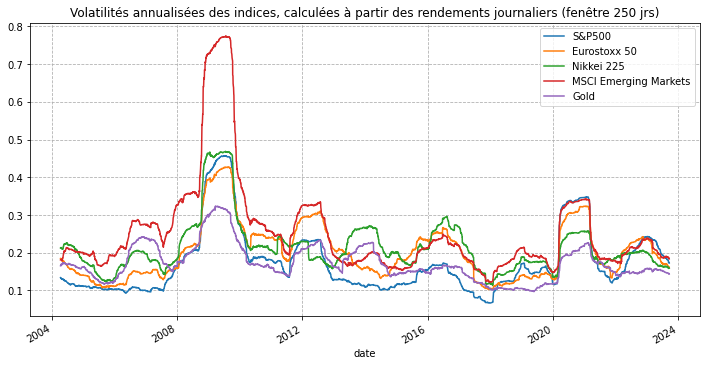

In [25]:
annualized_roll_vol.plot(figsize=(12,6))
plt.legend(["S&P500","Eurostoxx 50","Nikkei 225","MSCI Emerging Markets","Gold"])
plt.title("Volatilités annualisées des indices, calculées à partir des rendements journaliers (fenêtre 250 jrs)")
plt.grid(linestyle="--")
plt.show()

**Statistiques descriptives sur les volatilités annualisées**

In [26]:
statistics = annualized_roll_vol.agg(["min","median","mean","max"]) # agrégations
statistics.columns = ["S&P500","Eurostoxx 50","Nikkei 225","MSCI Emerging Markets","Gold"] # Renomage des variables
statistics =  statistics.T # Transposition pour un affichage plus claire
statistics = statistics.style.format("{:.2%}") # changement de format des valeurs pour les exprimer en pourcentage
statistics

,min,median,mean,max
S&P500,6.65%,14.69%,17.25%,45.69%
Eurostoxx 50,10.21%,18.41%,20.17%,42.74%
Nikkei 225,11.46%,19.93%,21.42%,46.84%
MSCI Emerging Markets,12.19%,21.11%,25.55%,77.43%
Gold,9.72%,16.19%,17.21%,32.35%


3. <a id='volatility_clusters'>Les clusters de volatilité</a>

<div style="text-align:justify;">
Le phénomène de cluster de volatilité (de grappe ou de groupement en français) traduit le fait que les jours de fortes volatilités ont tendance à être regroupé ensemble. Des épisodes de fortes volatilités qui sont suivis par des périodes de faible volatilité. C'est un phénomène que l'on retrouve pour tous les actifs financiers (actions, obligations, devises, matières premières, etc), avec plus ou moins d'intensité. 

<br>

C'est un phénomène que l'on peut voir facilement dans les graphiques au-dessus mais également ci-dessous :
</div>

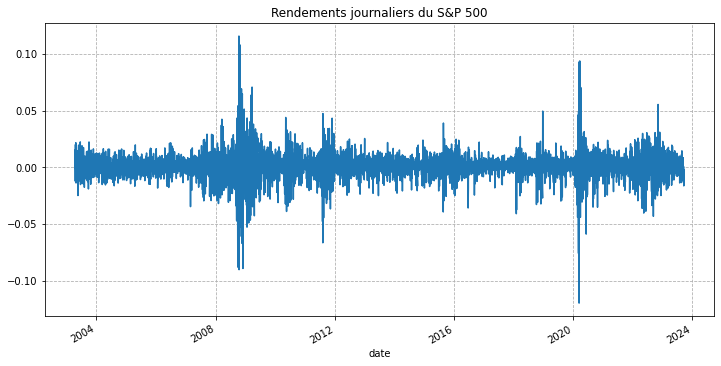

In [27]:
prices["GSPC.INDX"].pct_change().plot(figsize=(12,6))
plt.title("Rendements journaliers du S&P 500")
plt.grid(linestyle="--")
plt.show()

Au delà de l'aspect visuel, comment démontrer ce phénomème statistiquement ? Quelles sont les implications pour l'étude de la volatilité ?

<div style="text-align:justify;">
Pour démontrer l'existence des clusters, nous allons utiliser deux outils que sont la <b>fonction d'autocorrélation</b> et le <b>test de stationnarité</b>. En effet, si la volatilité était purement aléatoire, elle n'aurait pas d'autocorrélation, c'est à dire, que <b>la volatilité présente n'aurait aucun lien avec la volatilité passée</b>, et cette dernière ne nous serait d'aucune utilité pour prédire la volatilité future. 
<br><br>
En revanche, une autocorrélation positive signifierait que des éposides de forte volatilité seraient probablement suivis par d'autres épisodes de volatilité, ce qui serait cohérent avec l'existence des clusters, et cela impliquerait que l'<b>on puisse prédire la volatilité future à partir de la volatilité passée</b>.
<br><br>
Enfin si la volatilité était une variable purement aléatoire, elle serait <b>stationnaire</b> à travers le temps, et aurait donc <b>une moyenne, une variance et une autocorrélation constante</b>. Dans le cas contraire, ces paramètres seraient susceptibles de varier de manière significative au fil du temps, ce qui valide donc l'existence des clusters.   
</div>

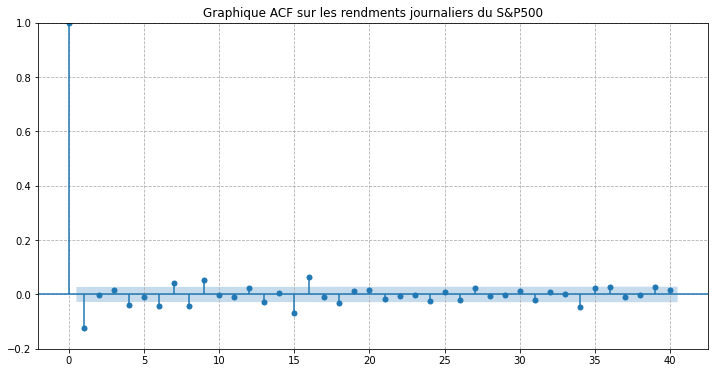

In [28]:
acf_plot_dailyReturns = sm.graphics.tsa.plot_acf(prices["GSPC.INDX"].pct_change().dropna(), lags=40)
acf_plot_dailyReturns.set_size_inches((12, 6))
plt.ylim([-0.2, 1.])
plt.title("Graphique ACF sur les rendments journaliers du S&P500")
plt.grid(linestyle="--")
plt.show()

<div style="text-align:justify;">
Lorsqu'on observe la fonction d'autocorrelation sur les rendements journaliers les points qui sortent de l'intervalle de confiance semblent complètement aléatoires, ce qui tend à montrer qu'il n'y a aucune structure d'autocorrélation dans cette série temporelle. Les rendements passés semblent donc n'avoir aucun pouvoir de prédiction sur les rendements futures, ce qui justifie l'adage :
</div>

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black; text-align:center"> 
    <b>Les rendements du passé ne présagent en rien des rendements du future.</b>
</p>

Stationnarité des séries temporelles :
<br><br>

<div style="text-align:justify;">
&#129504;
La stationnarité implique que la structure du processus sous-jacent n'est pas sensible à l'évolution du temps, ainsi, un processus qui reste stable à travers le temps est jugé stationnaire. Autrement dit, que l'on regarde notre série temporelle à l'instant t, ou à l'instant t + k, elle devrait conserver les mêmes propriétés. 
</div>


**Définition faible de la stationnarité :**

> Soit un processus temporel à valeurs réelles et en temps discret $Z_{1}, Z_{2},...Z_{t}$. Il est dit stationnaire au sens faible (ou "de second ordre", ou "en covariance") si :
>- $E[Z_{i}] = \mu$,  $\forall i = 1...t$
>- $Var[Z_{i}]= \sigma^{2} \ne \infty$,  $\forall i = 1...t$
>- $Cov[Z_{i}, Z_{i-k}] = f(k) = \rho_{k}$,  $\forall i = 1...t$,  $\forall k = 1...t$

**Interprétation :**
- La première condition impose que la l'espérance est contante au cours du temps, il n'y donc pas de tendance;
- La seconde condition traduit le fait que la variance est constante au cours du temps et non inifie;
- La troisième condition mentionne que l'auto-corrélation (ou l'auto-covariance) entre $Z_{i}$ et $Z_{i-k}$ dépend uniquement de l'ampleur de k, et non du temps. 

**Hypothèses du test :**
- H0 : existence d'une racine unitaire -> série temporelle non stationnaire (p-value > 0.05)
- H1 : aucune racine unitaire -> série temporelle stationnaire (p-value < 0.05)

In [29]:
def adf_test_analysis(adf_results):
    if adf_results[1] < 0.05:
        unit_root = False
        stationarity = True
    else:
        unit_root = True
        stationarity = False
    
    results = {
        "Statistics":adf_results[0],
        "p-value":adf_results[1],
        "sample-size":adf_results[3],
        "critical-values":adf_results[4],
        "unit-root":unit_root,
        "stationarity":stationarity
    }
    return results

In [30]:
adf_dailyRet_LT = adfuller(prices["GSPC.INDX"].pct_change().dropna(), maxlag=40, regression="ct")
adf_test_analysis(adf_dailyRet_LT)

{'Statistics': -17.71468334793969,
 'p-value': 0.0,
 'sample-size': 5123,
 'critical-values': {'1%': -3.9605382323255793,
  '5%': -3.4113473424827485,
  '10%': -3.127554853992851},
 'unit-root': False,
 'stationarity': True}

In [31]:
adf_dailyRet_ST = adfuller(prices["GSPC.INDX"].pct_change().dropna()[-150:], maxlag=40, regression="ct")
adf_test_analysis(adf_dailyRet_ST)

{'Statistics': -9.311075364891737,
 'p-value': 7.275739389558725e-14,
 'sample-size': 148,
 'critical-values': {'1%': -4.02127882271287,
  '5%': -3.440581388836791,
  '10%': -3.144706364874736},
 'unit-root': False,
 'stationarity': True}

<div style="text-align:justify;">
Le test de Dickey-Fuller augmenté montre que ce soit à long terme ou court terme (échantillon des 150 derniers rendements), les rendements journaliers semblent être stationnaires, ce qui vient confirmer l'intuition du graphique ACF ci-dessus.
</div>

Ci-dessous, nous allons reprendre la même analyse en élevant les rendements au carré pour construire un proxy de la volatilité :

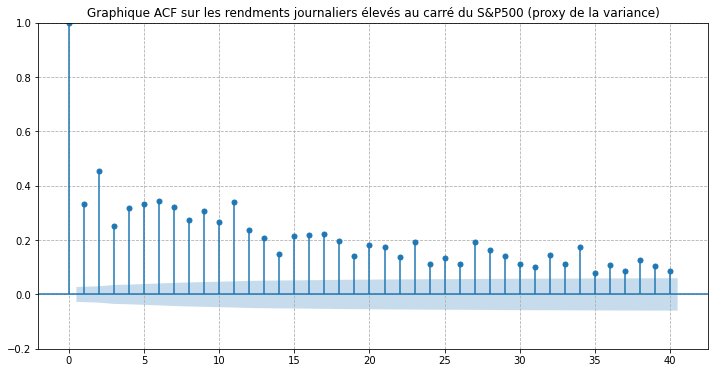

In [32]:
acf_plot_squaredReturns = sm.graphics.tsa.plot_acf(prices["GSPC.INDX"].pct_change().dropna()**2, lags=40)
acf_plot_squaredReturns.set_size_inches((12, 6))
plt.ylim([-0.2, 1.])
plt.title("Graphique ACF sur les rendments journaliers élevés au carré du S&P500 (proxy de la variance)")
plt.grid(linestyle="--")
plt.show()

In [33]:
adf_dailyRet_LT_squared = adfuller(prices["GSPC.INDX"].pct_change().dropna()**2, maxlag=40, regression="ct")
adf_test_analysis(adf_dailyRet_LT_squared)

{'Statistics': -7.859762641807078,
 'p-value': 1.5073646264507843e-10,
 'sample-size': 5105,
 'critical-values': {'1%': -3.9605444708728506,
  '5%': -3.4113503666543483,
  '10%': -3.1275566346156354},
 'unit-root': False,
 'stationarity': True}

In [34]:
adf_dailyRet_ST_squared = adfuller(prices["GSPC.INDX"].pct_change().dropna()[-150:]**2, maxlag=40, regression="ct")
adf_test_analysis(adf_dailyRet_ST_squared)

{'Statistics': -2.6912232172608843,
 'p-value': 0.2397448150600277,
 'sample-size': 128,
 'critical-values': {'1%': -4.0312964212608335,
  '5%': -3.445363149681091,
  '10%': -3.147500234603882},
 'unit-root': True,
 'stationarity': False}

<div style="text-align:justify;">
La même analyse faite sur les rendements élevés au carré montre des résultats quelques peu différents. A long terme, même les rendements élevés au carré semblent produire une série stationnaire, cependant, à court terme les résultats indiquent que <b>la série est non stationnaire</b>.
<br><br>
En effet, si on regarde le graphique ACF des rendements élevés au carré, on observe qu'il existe, à court terme, une corrélation entre les rendements, mais qui a tendance à baisser avec le temps. Ainsi, le dernier rendement (les plus récents) semblent être plus sensible aux variations récentes qu'aux variations anciennes. A court terme au moins, la dimension temporelle devient importante.
</div>

4. <a id='leptokurtic_distribution'>Distribution leptokurtique</a>

<div style="text-align:justify;">
Une distribution leptokurtique est une distribution de probabilité dont la queue est plus épaisse que celle d'une distribution normale. Cela signifie que les valeurs extrêmes, positives ou négatives, sont plus fréquentes dans une distribution leptokurtique que dans une distribution normale.
<br><br>
Pour illustrer ce concept, on peut comparer la distribution normale des rendements d'un des indices de notre jeu de données, à une distribution normale.
</div>

In [35]:
mean_of_returns = simple_returns.mean()
std_of_returns = simple_returns.std()

In [36]:
kde = sm.nonparametric.KDEUnivariate(simple_returns)
kde.fit()
norm_distrib = stats.norm.pdf(loc=mean_of_returns, scale=std_of_returns, x=kde.support)

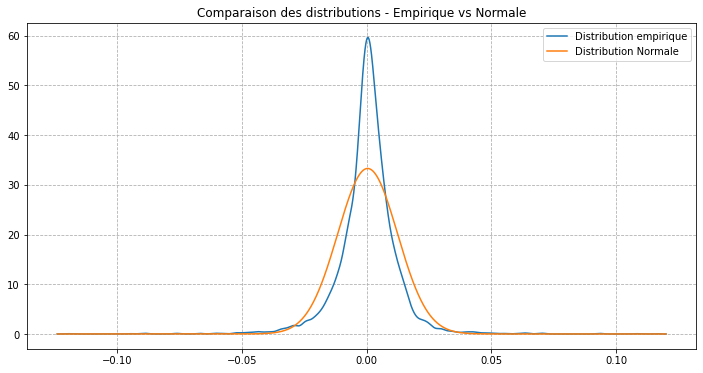

In [37]:
plt.figure(figsize=(12,6))
plt.plot(kde.support, kde.density)
plt.plot(kde.support, norm_distrib)
plt.title("Comparaison des distributions - Empirique vs Normale")
plt.legend(["Distribution empirique", "Distribution Normale"])
plt.grid(linestyle="--")

Le graphique ci-dessus montre plusieurs éléments intéressants :
- la distribution empirique possède plus rendement proches de 0 que la distribution normale;
- la distribution empirique est au dessus de la distribution normale aux extrémités des distributions, ce qui démontre que les évènnements extrêmes sont sous représentés dans une loi normale.

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black; text-align:justify"> 
<b>A noter que les données utilisées pour ce notebook ne démarrent qu'en 2004, ce qui veut dire qu'il manque des crises dans l'échantillon, et que les queues de distributions devraient être en réalité plus épaisses !!! De plus, les indices de marchés étant souvent diversifiés, ils sont moins soumis aux évènnements extrêmes que des single stock par exemple.</b>
</p>
    
Pour appuyer mon propos, je vais "zoomer" sur les distributions !

In [38]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

&#x1F4A1;
J'importe ici des modules permettant ce "zoom". Ce sont des composants de la librairie matplotlib.
Je ne les ai pas mis en début de script comme il est recommandé de faire, car je ne les utilise que rarement, et dans le cas présent ce n'est que pour illustrer mon propos.

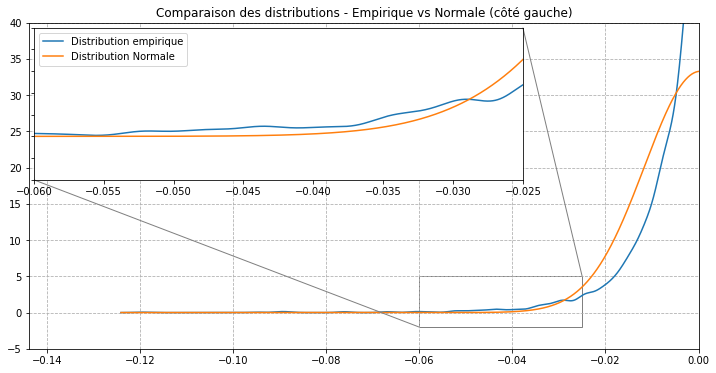

In [39]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.plot(kde.support, kde.density)
ax.plot(kde.support, norm_distrib)
ax.grid(linestyle="--")
plt.title("Comparaison des distributions - Empirique vs Normale (côté gauche)")

# Limites du graphique sur l'axe des abscisses
x1 = simple_returns.min() * 1.20 # Limite à gauche avec un peu d'espace i.e *1.20
x2 = 0.0 # Limite au centre de la distribution

# Limites du graphique sur l'axe des ordonnées
y1 = -5 # Je démarre un peu en dessous pour avoir un peu d'espace
y2 = 40 # limite haute du graphique

# Definition des limites du graphique initial
ax.set_xlim(x1, x2) # limites sur l'axe des abscisses
ax.set_ylim(y1, y2) # limites sur l'axe des ordonnées

# Définition des limites du sous graphique (le zom)
x1bis = -0.06 # première limite de l'intervalle x (abscisse)
x2bis = -0.025 # deuxième limite de l'intervalle x (abscisse)

# Définition des limites du sous graphique (le zom)
y1bis = -2 # première limite de l'intervalle y (ordonnées)
y2bis = 5 # deuxième limite de l'intervalle y (ordonnées)

# Définition et création du graphique de zoom
axins = zoomed_inset_axes(ax, 3, loc=2) # zoom x3
axins.plot(kde.support, kde.density) # plot de la distribution empirique
axins.plot(kde.support, norm_distrib) # plot de la distribution normale
axins.set_xlim(x1bis, x2bis) # definition des limites du sous graphique (abscisse)
axins.set_ylim(y1bis, y2bis) # même chose sur les ordonnées
plt.xticks(visible=True) # je fais apparaître uniquement l'axe des abscisses
plt.yticks(visible=False) # pour l'axe des ordonnée je trouve l'information inutile
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.5") # creation du graphique avec location
plt.legend(["Distribution empirique", "Distribution Normale"])
plt.draw()

plt.show()

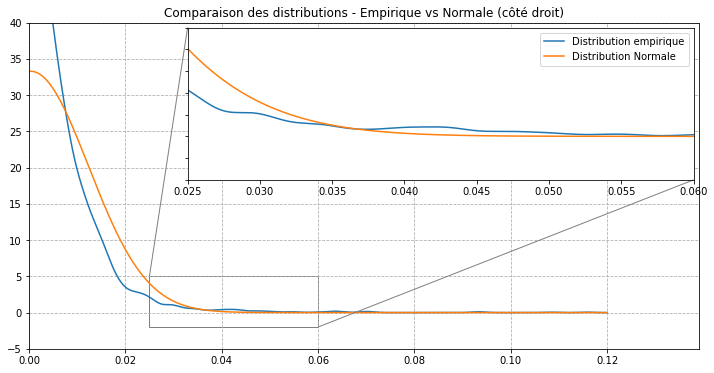

In [40]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.plot(kde.support, kde.density)
ax.plot(kde.support, norm_distrib)
ax.grid(linestyle="--")
plt.title("Comparaison des distributions - Empirique vs Normale (côté droit)")

x1 = 0.0
x2 = simple_returns.max() * 1.20

y1 = -5
y2 = 40

ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)

x1bis = 0.025
x2bis = 0.06

y1bis = -2
y2bis = 5

axins = zoomed_inset_axes(ax, 3, loc=1) 
axins.plot(kde.support, kde.density)
axins.plot(kde.support, norm_distrib)
axins.set_xlim(x1bis, x2bis)
axins.set_ylim(y1bis, y2bis)
plt.xticks(visible=True)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=4, loc2=2, fc="none", ec="0.5")
plt.legend(["Distribution empirique", "Distribution Normale"])
plt.draw()

plt.show()

<div style="text-align:justify;">
Des deux côtés de la distribution, on voit bien que la fréquence des rendements extrêmes est bien plus importante que pour la loi normale. Il est également possible de mettre ce phénomène en lumière en utilisant les statistiques de <b>skewness</b> et de <b>kurtosis</b>.
</div>

5. <a id='nonlinear_dependance'>La dépendance non linéaire</a>

<div style="text-align:justify;">
La dépendance, fait référence au fait que des actifs financiers peuvent être plus ou moins sensibles à l'évolution d'autres actifs financiers. Cette dépendance est dîte non linéaire car l'amplitude de ces variations ainsi que son timing peut varier selon les conditions de marché.
<br><br>
La plupart du temps, les prix des actifs financiers évoluent de façon relativement indépendant. Cependant, lors des phases de stress sur les marchés, beaucoup d'actifs baissent en même temps, ce qui se traduit par une hausse de la corrélation entre ces derniers.
</div>

Ce phénomène de dépendance peut-être exprimé à travers plusieurs types de méthodes, plus ou moins complexes :
- la covariance
- la corrélation
- via un modèle linéaire (e.g regression linéaire)
- via un modèle non linéaire (e.g les copules)

Economiquement parlant, ce phénomène s'explique par :
- le phénomène de contagion : aujourd'hui l'économie, ainsi que les marchés sont mondialisés. Ainsi un événnement dans un coin du monde peut avoir des effets à l'autre bout du monde. La rupture des usines en Chine lors du Covid a eu des impacts jusque là insoupconnés sur toutes les chaînes d'approvisionnement du monde.
- l'effet de levier : les investisseurs utilisent souvent l'effet de levier pour amplifier leurs gains. Lors d'une phase de stress, les investisseurs sont plus susceptibles de liquider leurs positions à effet de levier, ce qui entraîne une baisse des prix des actifs sous-jacents. Cela augmente également la corrélation entre les rendements des différents actifs.
- la baisse de la liquidité : lors d'une phase de stress, la liquidité sur les marchés financiers diminue. Cela signifie qu'il est plus difficile pour les investisseurs de vendre leurs actifs. Cela entraîne une baisse des prix des actifs, ce qui augmente également la corrélation entre les rendements des différents actifs.


In [41]:
long_period_correlation = prices.pct_change().corr()
stress_period_correlation = prices[(prices.index >= "2019-12-31") & (prices.index <= "2020-12-31")].corr()

In [42]:
# Cette fonction permet juste de formater mon tableau de sortie
def make_pretty(styler):
    styler.set_caption("Matrice de corrélation") # ajout d'un titre
    styler.background_gradient(cmap='coolwarm') # background des cellules en fonction de leur valeur
    styler.format(precision=2) # nombre avec 2 decimales après la virgule
    styler.set_properties(**{'text-align': 'center'}) # valeurs centrées
    return styler

# permet juste d'améliorer le rendu d'un simple df.corr()

In [43]:
# On utiliser ensuite le styler que nous avons définit juste au-dessus
long_period_correlation.style.pipe(make_pretty)

,GSPC.INDX,SX5E.INDX,N225.INDX,EEM.US,GC.COMM
GSPC.INDX,1.00,0.61,0.15,0.82,0.02
SX5E.INDX,0.61,1.00,0.32,0.58,0.00
N225.INDX,0.15,0.32,1.00,0.18,0.03
EEM.US,0.82,0.58,0.18,1.00,0.12
GC.COMM,0.02,0.00,0.03,0.12,1.00


In [44]:
stress_period_correlation.style.pipe(make_pretty)

,GSPC.INDX,SX5E.INDX,N225.INDX,EEM.US,GC.COMM
GSPC.INDX,1.00,0.74,0.96,0.97,0.56
SX5E.INDX,0.74,1.00,0.78,0.75,-0.02
N225.INDX,0.96,0.78,1.00,0.96,0.42
EEM.US,0.97,0.75,0.96,1.00,0.50
GC.COMM,0.56,-0.02,0.42,0.50,1.00


Ces résultats illustrent bien le fait qu'en période de stress, les actifs se recorrellent. Un des résultats le plus marquant est la passage de la corrélation entre l'indice des actions émergentes (EEM.US) et les actions japonaises passer de 18% en marché "normale" à 96% lors de la crise du Covid.

On peut également observer que la corrélation entres les différents marchés et l'or a augmentée de 40 bp durant cette même période (exception faite de l'Eurostoxx 50).

Et pour rajouter une dimension temporelle à cette analyse, il suffit de mesurer l'évolution des corrélations dans le temps :

In [45]:
daily_returns = prices.pct_change().dropna()
corr_spx_sx5e = daily_returns["GSPC.INDX"].rolling(252).corr(daily_returns["SX5E.INDX"])
corr_spx_eem = daily_returns["GSPC.INDX"].rolling(252).corr(daily_returns["EEM.US"])
corr_spx_n225 = daily_returns["GSPC.INDX"].rolling(252).corr(daily_returns["N225.INDX"])
corr_spx_gc = daily_returns["GSPC.INDX"].rolling(252).corr(daily_returns["GC.COMM"])

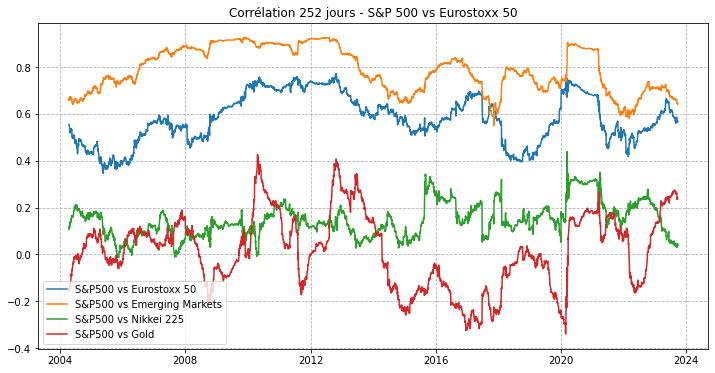

In [46]:
plt.figure(figsize=(12,6))
plt.plot(corr_spx_sx5e)
plt.plot(corr_spx_eem)
plt.plot(corr_spx_n225)
plt.plot(corr_spx_gc)
plt.legend(["S&P500 vs Eurostoxx 50", "S&P500 vs Emerging Markets","S&P500 vs Nikkei 225","S&P500 vs Gold"])
plt.title("Corrélation 252 jours - S&P 500 vs Eurostoxx 50")
plt.grid(linestyle="--")

<div style="text-align:justify;">
On observe bien les hausses de corrélation lors des phases de stress sur les marchés, notamment en 2008 lors de la crise des subprimes, en 2012 lors de la crise des dettes souvereines en Europe, le Brexit avec la montée des eurosceptiques en 2016, ou encore le Covid en 2020.
</div>

<u><b><a id='univariate_model'>II. Modélisation univariée</a></b></u>

<div style="text-align:justify;">
    <br>
Nous avons vu que les sources de risque de marché peuvent prendre plusieurs formes, notamment la variation, la dépendance, ou les deux à la fois. Dans les paragraphes qui suivent, nous étudierons différentes méthodes de modélisation, en mettant l'accent sur leurs avantages et leurs inconvénients.
</div>

1. <a id='moving_average'>Moving Average</a>

<div style="text-align:justify;">
    <br>
La modélisation la plus simple consiste à mesurer l'écart-type des rendements sur un intervalle de temps, et à chaque moment, rajouter une nouvelle donnée de rendement, et en retirer une ancienne. C'est ce que nous faisons en calculant la volatilité sur une fenêtre roulante avec la fonction <i>rolling_volatility</i>.
</div>

Pour plus de formalisme, voici l'équation de la moyenne mobile :

$\hat{\sigma}_{t} = \sqrt{\frac{1}{T}\sum_{t=1}^{T}{(r_{t}-\bar{r})^2}}$

avec :
- $r_{t}-\bar{r}$, la différence entre le rendement à l'instant t le rendement moyen de l'actif. Si on fait l'hypothèse que que $\bar{r}$ est égale à 0, alors l'écart à la moyenne est le rendement au carré.
- $\hat{\sigma}_{t}$, la prévision de volatilité pour l'instant t;
- $T$, la longueur de notre fenêtre d'observation (le paramètre span dans notre fonction rollind_volatility)

<div style="text-align:justify;">
    <br>
Ce genre de modélisation à l'avantage d'être simple, de rendre une image précise du passé, mais elle souffre également de grands déficites :
    la moyenne arithmétique donne <b>autant de poids à chaque rendement</b> sur la période d'observation. Cependant, nous avons observé précédemment, notamment avec l'analyse de l'autocorrélation, que <b>les rendements récents avaient plus d'impact sur la volatilité courante</b>, que les rendements plus anciens.
</div>

In [21]:
def rolling_volatility(prices, span):
    returns = prices.pct_change()
    return returns.rolling(span).std()

Nous pouvons réécrire la fonction ci-dessus de la manière suivante :

In [47]:
daily_returns = prices["GSPC.INDX"].pct_change().dropna()    
SPAN = 20

In [48]:
def centered_returns(df_returns):
    centered = df_returns - df_returns.mean() # différence entre les rendements et la moyenne
    return centered**2 # élevés au carré
    
def sma(returns, span): # implémentation de l'équation.
    centered = centered_returns(returns)
    equal_weights = np.ones(span) / span # si on divise par span - 1 on obtient les mêmes résultats que pandas.std()
    cum_prod = np.dot(equal_weights, centered)
    return np.sqrt(cum_prod)

In [49]:
historical_sma = daily_returns.rolling(SPAN).apply(lambda x: sma(x, SPAN)) * np.sqrt(252)

2. <a id='ewma'>Exponentially Weighted Moving Average (EWMA)</a>

Il est possible d'améliorer la modélisation précédente en donnant plus de poids aux variations récentes, et c'est ce que nous allons voir avec la moyenne mobile exponentielle.

Comme on peut le voir dans l'équations ci-dessous le poids des variations sera fonction le $\lambda$ et va décroitre avec le temps, de façon exponentielle.

$\hat{\sigma}_{t} = \sqrt{(1-\lambda)\sum_{t=1}^{T}\lambda^{t-1}(r_{t}-\bar{r})^2}$

avec :
- $r_{t}-\bar{r}$, la différence entre le rendement à l'instant t le rendement moyen de l'actif. Si on fait l'hypothèse que que $\bar{r}$ est égale à 0, alors l'écart à la moyenne **est le rendement au carré**.
- $\hat{\sigma}_{t}$, la prévision de volatilité pour l'instant t;
- $T$, la longueur de notre fenêtre d'observation (le paramètre span dans notre fonction <i>rolling_volatility</i>)
- $\lambda$, le "Decay Factor" c'est à dire le facteur de décroissance, qui doit être compris entre 0 et 1.



Pour vous en convaincre, je <i>plot</i> ci-dessous les coefficients multiplicatifs liés à chaque instant de notre équation entre t et T ($\lambda^{t-1}$) pour différents niveaux de $\lambda$ :

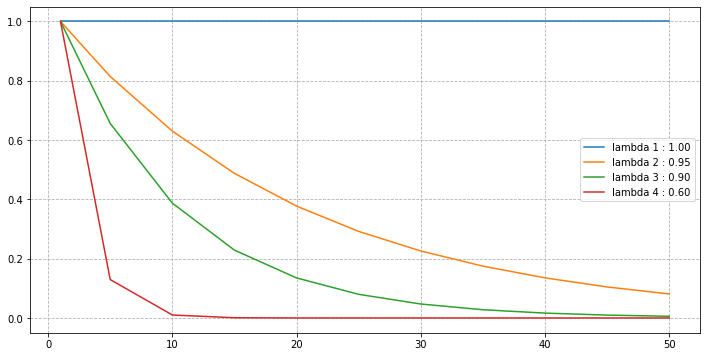

In [50]:
lbda_1 = 1.00
lbda_2 = 0.95
lbda_3 = 0.90
lbda_4 = 0.60

tenors = [1,5,10,15,20,25,30,35,40,45,50]

decays_1 = []
decays_2 = []
decays_3 = []
decays_4 = []
for tnr in tenors:
    decays_1.append(lbda_1**(tnr-1))
    decays_2.append(lbda_2**(tnr-1))
    decays_3.append(lbda_3**(tnr-1))
    decays_4.append(lbda_4**(tnr-1))

plt.figure(figsize=(12,6))
plt.plot(tenors, decays_1, label=f"lambda 1 : {lbda_1:0.2f}")
plt.plot(tenors, decays_2, label=f"lambda 2 : {lbda_2:0.2f}")
plt.plot(tenors, decays_3, label=f"lambda 3 : {lbda_3:0.2f}")
plt.plot(tenors, decays_4, label=f"lambda 4 : {lbda_4:0.2f}")
plt.legend()
plt.grid(linestyle="--")

<div style="text-align:justify;">
Sachant que $\lambda^{n} \rightarrow 0$ à mesure que $n \rightarrow \infty$, il est facile de comprendre que les rendements les plus anciens ont moins d'incidence sur l'estimation. Ensuite, il convient de modifier $\lambda$ pour accentuer ce phénomène.
    <br><br>
Evidemment fournir un $\lambda$ égal à 1 revient à donner à chaque observation le même poids (cf graphique).
    <br><br>
Lorsque cette modélisation a été proposée pour la première fois par JP Morgan, ils ont suggeré que $\lambda$ soit égal à 0.94 pour des rendements journaliers, et c'est encore une pratique commune de nos jours.
</div>

In [51]:
def decay_coefficients(lbda, span):
    lbda_vec = np.ones(span) * lbda # creation d'un vector de lambda
    lbda_tenor = np.ones(span) * np.arange(span, 0, -1) # on va de span à 0, ce qui équivaut t-1
    coefficients = lbda_vec**lbda_tenor
    return coefficients
    
def centered_returns(df_returns):
    centered = df_returns - df_returns.mean() # différence entre les rendements et la moyenne
    return centered**2 # élevés au carré
    
def ewma(returns, lbda, span): # implémentation de l'équation.
    centered = centered_returns(returns)
    decay_coef = decay_coefficients(lbda, span)
    cum_prod = np.dot(decay_coef, centered)
    return np.sqrt((1 - lbda) * cum_prod)

<div style="text-align:justify;">
Dans les graphiques ci-dessous on compare les estimations de volatilité à travers le temps, avec notre fonction ewma selon différents paramètres, et avec une méthode de pandas.
<br><br>
    Il est important de noter que la fonction de pandas <i>pandas.ewm()</i> ne permet pas de définir plusieurs paramètres simultanéments, c'est pourquoi je fourni uniquement le span. Cela s'explique par le fait que les calculs sous-jacents sont quelques peu différents, et c'est pourquoi nous obtenons des différences dans les résultats.
</div>

In [52]:
historical_ewma = daily_returns.rolling(SPAN).apply(lambda x: ewma(x, 0.94, SPAN)) * np.sqrt(252)
historical_ewma_bis = daily_returns.rolling(SPAN).apply(lambda x: ewma(x, 0.80, SPAN)) * np.sqrt(252)
pandas_ewma = daily_returns.ewm(span = SPAN, adjust=False).std() * np.sqrt(252)

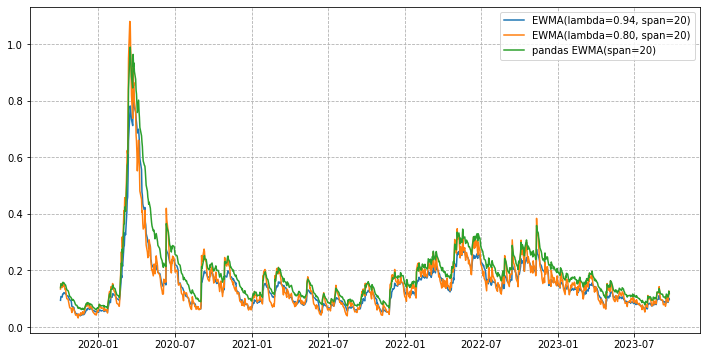

In [53]:
plt.figure(figsize=(12,6))
plt.plot(historical_ewma.tail(1000), label="EWMA(lambda=0.94, span=20)")
plt.plot(historical_ewma_bis.tail(1000), label="EWMA(lambda=0.80, span=20)")
plt.plot(pandas_ewma.tail(1000), label="pandas EWMA(span=20)")
plt.legend()
plt.grid(linestyle="--")

Dans le graphique ci-dessous, je compare les méthodes SMA et EWMA :

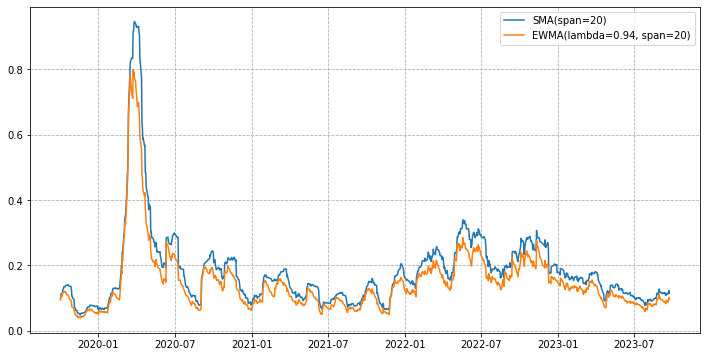

In [54]:
plt.figure(figsize=(12,6))
plt.plot(historical_sma.tail(1000), label="SMA(span=20)")
plt.plot(historical_ewma.tail(1000), label="EWMA(lambda=0.94, span=20)")
plt.legend()
plt.grid(linestyle="--")

<div style="text-align:justify;">
Les graphiques montrent clairement que la volatilité mesurée selon la méthode EWMA est "plus réactive" que celle calculée par SMA, ce qui est plus réaliste. Cependant, un des incovénients de cette méthode est que <b>$\lambda$ est constant dans le temps et à priori identique pour tous les actifs financiers</b>, ce qui est en revanche peu réaliste.
</div><br>
<div style="text-align:justify;">
Un aspect intéressant de cette modélisation est qu'il est possible de réécrire l'estimateur de la variance sous une forme récursive afin d'effectuer des prévisions pour le future. En Effet, si on fait l'hypothèse que $\bar{r} = 0$ alors la variance à l'instant t+1 peut-être définie à partir de la variance connue à l'instant t :
</div>

$\sigma^{2}_{t+1|t} = \lambda \sigma^{2}_{t|t-1} + (1-\lambda)r^{2}_{t}$ (1)

<div style="text-align:justify;">
    <br>
Cette notation met en avant le fait que la variance est dépendante du temps, c'est ce que nous avions montré plus haut lors de l'analyse de l'autocorrélation des rendements élevés au carré.
    
On obtient l'équation (1) de la manière suivante :
    
$\sigma^{2}_{1,t+1|t} = (1-\lambda)\sum_{t=0}^{\infty}\lambda^{i}r^{2}_{1,t-i}$

$=(1-\lambda)(r^{2}_{1,t} + \lambda r^{2}_{1,t-1} + \lambda^{2} r^{2}_{1,t-2} + ...)$

$=(1-\lambda)r^{2}_{1,t} + \lambda(1-\lambda) (r^{2}_{1,t-1} + \lambda r^{2}_{1,t-2} + \lambda^{2} r^{2}_{1,t-3} + ...)$
    
Si on fait l'hypothèse que $\bar{r} = 0$ alors on peut réécrire ci-dessus comme :
    
$=(1-\lambda)r^{2}_{1,t} + \lambda (1-\lambda)\sum_{t=1}^{\infty}\lambda^{i-1}(r_{1,t-i} - \bar{r})^{2}$
    
$=(1-\lambda)r^{2}_{1,t} + \lambda (1-\lambda)\sum_{t=1}^{\infty}\lambda^{i-1}r^{2}_{1,t-i}$    
    
    
Démonstration :
    
t = 1 --> $\lambda^{1-1}r^{2}_{t-1} = \lambda^{0}r^{2}_{1,t-1}=r^{2}_{1,t-1}$
    
t = 2 --> $\lambda^{2-1}r^{1}_{t-2} = \lambda^{1}r^{2}_{1,t-2}=\lambda r^{2}_{1,t-2}$ 
    
t = 3 --> $\lambda^{3-1}r^{2}_{t-3} = \lambda^{2}r^{2}_{1,t-3}$ 
    
    
Nous avons déjà vu cette forme, c'est la formule de la variance ewma, ce qui nous permet de réécrire :
    
$\sigma^{2}_{1,t+1|t}=(1-\lambda)r^{2}_{1,t} + \lambda \sigma^{2}_{1,t|t-1}$
</div>

Pour effectuer des prévisions sur une période plus longue, il suffit de multiplier la prévision de variance (ou d'écart-type) à 1 jour par T (ou $\sqrt{T})$ comme suit :

$\sigma^{2}_{1,t+T|t} = T\sigma^{2}_{1,t+1|t}$  ou  $\sigma_{1,t+T|t} = \sqrt{T}\sigma_{1,t+1|t}$

In [55]:
def ewma_forecast(last_return, last_variance, lbda, days=1):
    return days * (1-lbda)*last_return**2 + days * lbda * last_variance

<div style="text-align:justify;">
Des précautions importantes doivent être prises lorsqu'on tente d'effectuer des prévisions de volatilité avec cette méthode car bien que multiplier la prévision de variance à 1 jour par la racine du temps soit juste mathématiquement, elle est finalement peu réaliste.
</div>
    
A titre d'exemple, essayons de nous placer au 31/12/2021 et d'estimer la volatilité à 1 an de l'indice S&P 500 :

Pour cela, nous avons besoin de :
- La volatilité à le jour d'avant cette date : pour cela, nous commençons par reconstruire la série temporelle de volatilité avec la fonction recursive_variance.
- Le rendement à cette date. 

Pour que ce soit visuel, nous estimerons toutes les prévisions de volatilité entre 1 et 250 jours ouvrés que nous utiliserons comme une intervalle de confiance.

In [56]:
def recursive_variance(returns, lbda):
    recursive_var = []
    for i in range(0, returns.shape[0]):
        if i == 0: # initialisation de la variance avec le rendement au carré, 
            recursive_var.append(returns.iloc[0]**2) # car à l'instant 0 nous n'avons pas de variance passée
        else:
            recursive_var.append(ewma_forecast(returns.iloc[i], recursive_var[-1], lbda))

    return pd.DataFrame(recursive_var, index=returns.index, columns=["recursive_variance"])  

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">
&#x1F4A1;
<b>Note :</b><br>
Cette méthode est valable parce que notre série temporelle est longue. Comme nous l'avons vu plus haut, avec un lambda à 0.94, passé 60 jours environ, les rendements passés n'ont plus d'impact. Plus T augmente, plus le résultats va converger vers la variance récursive.
</p>

In [57]:
spx_recursive_var = recursive_variance(daily_returns.dropna(), 0.94)

<div style="text-align:justify;">
A titre de comparaison, je compare notre série de volatilité calculée à partir de la méthode de la prévision à un jour (aussi appelée variance récursive) à notre méthode par <i>ewma</i>. 
</div>

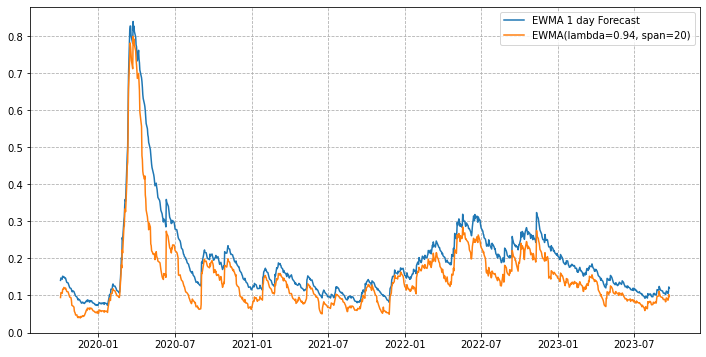

In [58]:
plt.figure(figsize=(12,6))
plt.plot(np.sqrt(spx_recursive_var.tail(1000))*np.sqrt(252), label="EWMA 1 day Forecast")
plt.plot(historical_ewma.tail(1000), label="EWMA(lambda=0.94, span=20)")
plt.legend()
plt.grid(linestyle="--")

In [59]:
last_return = daily_returns[daily_returns.index == "2021-12-31"].values
last_variance = spx_recursive_var[spx_recursive_var.index == "2021-12-30"].values

In [60]:
yr_2022 = daily_returns[(daily_returns.index >= "2021-12-31") & (daily_returns.index <= "2022-12-31")]
rebased_returns = (1 + yr_2022).cumprod() - 1

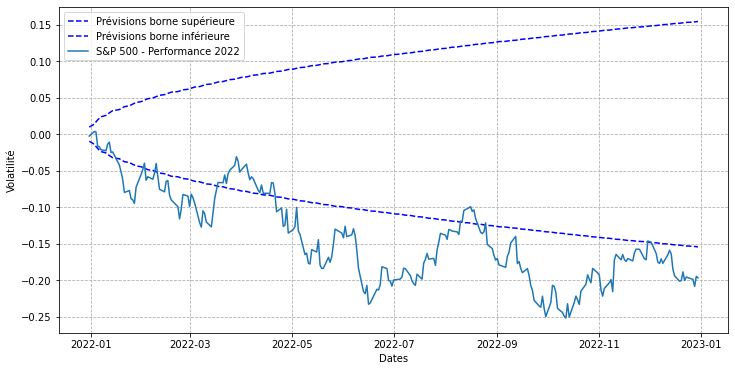

In [61]:
fcast_days = np.arange(1, yr_2022.shape[0]+1, 1)
results = []
for fcast in fcast_days:
    results.append(float(np.sqrt(ewma_forecast(last_return, last_variance, 0.94, fcast))))
    
plt.figure(figsize=(12,6))  
plt.plot(rebased_returns.index, results, color="blue", linestyle="--", label="Prévisions borne supérieure")
plt.plot(rebased_returns.index, np.asarray(results)*-1, color="blue", linestyle="--", label="Prévisions borne inférieure")
plt.plot(rebased_returns, label="S&P 500 - Performance 2022")
plt.legend()
plt.xlabel("Dates")
plt.ylabel("Volatilité")
plt.grid(linestyle="--")

3. <a id='garch'>ARCH et GARCH</a>

<div style="text-align:justify;">
Il existe de nombreuses modélisations liées à la volatilité, mais les plus répondues et utilisées par les opérateurs de marché sont les modélisations de type GARCH (Generalized AutoRegressive Conditional Heteroskedasticity), introduites par Robert F. Engle en 1982.
</div>

Décomposons le nom du modèle :
- Generalized : ces modèles constituent une généralisation du modèle ARCH d'Engle
- AutoRegressive : ce sont des modèles qui ont une forme auto-regressive, c'est à dire des modèles dans lesquels la série expliquée dépend plus de ses valeurs passées que d'autres variables.
- Conditional Heteroscedasticity : cela veut dire que cette modélisation tient compte du fait que la variance conditionnelle est variable dans le temps.


<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black"> 
<b>Rappel Important !</b><br><br>
    <b>Variance Inconditionnelle :</b> c'est la variance inconditionnelle issue de la distribution des rendements, qui est considérée comme CONSTANTE à travers tout le jeu de données. Elle peut-être considérée comme la <b>moyenne de long terme de la variance</b>.
<br><br>
    <b>Variance Conditionnelle :</b> c'est la variance qui change à chaque nouvelle donnée dans l'historique des valeurs. Elle tient compte du fait que la distribution varie en fonction des données du moment. Elle est conditionnelle en ce sens qu'elle est fonction de la distribution des rendements à un instant donnée, et tient compte du phénomène de "clustering" évoqué plus haut.
<br><br>
&#129504;
Cela explique notamment pourquoi ces modélisations ne sont appliquées qu'aux rendements journaliers, intraday voire hebdomadaires. Sur des fréquences plus faibles (mensuelle, trimestrielle, etc), les rendements exhibent moins cette propriété de clustering.
</p>
<br>

Un modèle ARCH(q) peut-être définit de la manière suivante :

$\epsilon_{t} = \sigma_{t}Z_{t}$, $Z_{t}\sim N(0,1)$

avec :
- $\epsilon_{t}$ : l'innovation de la série que l'on peut également écrire $\epsilon_{t} = x_{t} - \mu$
- $Z_{t}$ : une normale centrée réduite

Le cas le plus simple étant celui du ARCH(1) où :

$\sigma_{t}^2 = \alpha_{0} + \alpha_{1}\epsilon_{t-1}^2$

Mais si on généralise cette modélisation, on obtient la forme suivante :

$\sigma_{t}^2 = \alpha_{0} + \alpha_{1}\epsilon_{t-1}^2 + ... + \alpha_{q}\epsilon_{t-q}^2 = \alpha_{0} + \sum_{i=1}^{q}\alpha_{i}\epsilon_{t-i}^2$


Dans les lignes qui vont suivre, nous utiliserons la librairie ARCH dont la documentation peut-être trouvée ici :
https://arch.readthedocs.io/en/latest/univariate/univariate.html

**Estimation du modèle ARCH(1)**

In [62]:
am = arch_model(daily_returns*100, mean="Constant", vol="ARCH", p=1)
# Nous aurions pu mettre un paramètre mean="Zero", mais comme on ne sait pas si la moyenne est nulle, on fait à minima 
# l'hypothèse qu'elle est constante, c'est pourquoi on utilise mean="Constant". 
# Cela concerne mu dans notre equation epsilon.
model = am.fit()
print(model.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 35392.99245053025
Iteration:      2,   Func. Count:     14,   Neg. LLF: 11550.413714831875
Iteration:      3,   Func. Count:     21,   Neg. LLF: 7826.768761930634
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7733.938967629658
Iteration:      5,   Func. Count:     30,   Neg. LLF: 7733.934501455618
Iteration:      6,   Func. Count:     34,   Neg. LLF: 7733.934454453287
Iteration:      7,   Func. Count:     38,   Neg. LLF: 7733.934453721471
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7733.934453721471
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7
                      Constant Mean - ARCH Model Results                      
Dep. Variable:              GSPC.INDX   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelih

<div style="text-align:justify;">
&#128293;
Comme vous pouvez le voir dans la notification juste au dessus, le module nous fait remarquer que multiplier nos données par 100 devrait permettre d'améliorer l'estimation des paramètres du modèle.
</div>

Nous allons nous arrêter ici un moment pour étudier le résumé de notre modélisation :



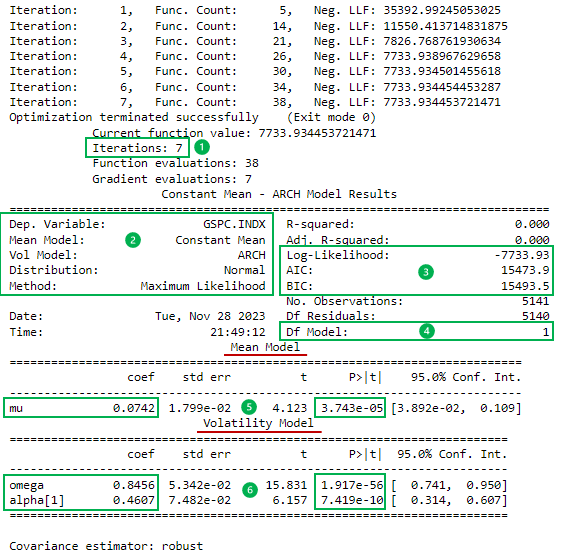

> Vous aurez remarqué que le résumé rappelle le type de la modélisation : **Constant Mean Arch model**
>
> Et chaque sous partie du modèle est représentée : 
>
> - Mean Model
> - Volatility Model

Décomposons le résumé :


1. Nombre d'itération pour obtenir la solution. Etant donné que notre modèle est simple, l'optimum est obtenu rapidement.


2. Rappel des éléments du modèle :

    - Dep. Variable : comme c'est un modèle auto regressif, la variable dépendante est elle même.
    - Mean Model : ne sachant pas si $\mu$ est égale à zéro, nous avons fait l'hypothèse qu'il est juste constant.
    - Vol Model : le summary nous rappel juste que nous sommes en train d'estimer une variance ARCH
    - Distribution : nous avons fait l'hypothèse que les rendements suivaient une loi normale
    - Method : méthode d'estimation des paramètres de notre modèle.
    
    
3. Statistiques permettant de juger de la qualité du modèle :

    - Log-Likelihood : 7 733.93 ***(the higher the better)***
    - AIC : 15 473.9 ***(the smaller the better)***
    - BIC : 15 493.5 ***(the smaller the better)***
    
    
4. Degrés de liberté du modèle : A noter que normalement je devrais obtenir 3 degrés de liberté car j'ai 3 variables dans mon modèle (mu, omega et alpha). **J'ignore pourquoi la sortie n'en mentionne qu'un seul.**


5. Nous avons ici l'estimation de $\mu$ (que l'on retrouve dans $\epsilon_{t} = x_{t} - \mu$) : 
    - $\mu$ vaut 0.0742
    - la p-value est inférieure à 0.05, ce qui implique que $\mu$ est significativement différent de 0. 
    
    
6. Résultats pour l'estimation des coéfficients omega et alpha1 ($a_{0}$ et $a_{1}$ dans notre modèle) :
    - $a_{0}$ vaut 0.8456 (la constante de notre modèle) et $a_{1}$ vaut 0.4607
    - Nos 2 coefficients sont significativement différents de 0 (p-value < 0.05).
    

Pour s'assurer que notre modélisation est bonne, il est possible de tracer un graphique acf (comme vu plus haut) sur les résidus de notre modèle (on les obtient grâce à l'attribut _resid). Si les résidus sont bruits blancs, c'est à dire compris dans l'intervalle de confiance, alors notre modèle est cohérent.

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">
&#x1F4A1;
<b>Expression de la volatilité de long terme d'un modèle ARCH :</b>
    <br>
    <br>
En l'absence de chocs, la variance devrait converger vers sa moyenne de long terme dont la valeur est $\bar{\sigma}^2$. Dans ce cas on peut considérer que $\sigma^2_{t} = \bar{\sigma}^2$ pour tout t. De plus, cette modélisation étant symétrique (les rendements négatifs sont traités de la même manière que les rendements positifs), on peut également considérer que $E(\epsilon^2_{t-1}) = \sigma^2_{t-1}$.
    <br>
    <br>
Cela nous permet de réécrire notre modèle initiale comme suit :
    <br>
    <br>
$\bar{\sigma}^2 = \omega + \alpha\bar{\sigma}^2$
    <br>
    <br>
$\bar{\sigma}^2(1 - \alpha) = \omega$ 
    <br>
    <br>
Et d'exprimer la variance "inconditionnelle" de long terme comme :
    <br>
    <br>
$\bar{\sigma}^2 = \frac{\omega}{1 - \alpha}$
    <br>
    <br>
Dans le cas où q serait supérieur à 1 (ARCH(q)), alpha serait remplacer par la sommes des paramètres alphas associés au coefficient q.
<p>

In [63]:
cm_arch1_lt_vol = np.sqrt(model.params[1] / (1 - model.params[2])) * np.sqrt(252)
print(f"Volatilité inconditionnelle de long terme issue de notre modélisation : {cm_arch1_lt_vol/100:.2%}")

Volatilité inconditionnelle de long terme issue de notre modélisation : 19.88%


Nous avons estimé les paramètres de notre modèle, et ils sont tous significatifs, nous pouvons maintenant calculer la volatilité basée sur ces derniers :

In [64]:
mu = model.params[0] # on accède aux paramètres du modèle via les attributs de la classe (le premier étant mu)
omega = model.params[1] # le second étant omega ou a0
alpha_one = model.params[2] # le troisième étant alpha1 ou a1
df_epsilon = (daily_returns*100) - mu
arch_var = df_epsilon.shift(1).apply(lambda x: omega + alpha_one * x**2) # shift pour décaler la série de 1 en arrière
arch_vol = np.sqrt(arch_var)/100 * np.sqrt(252)

A noter qu'il est possible d'accéder au calcul de la volatilité depuis notre modèle grâce à l'attribut **"_volatility"** de la classe ARCHModel.

In [65]:
df_mod_vol = pd.DataFrame(model._volatility/100, index=arch_vol.index)

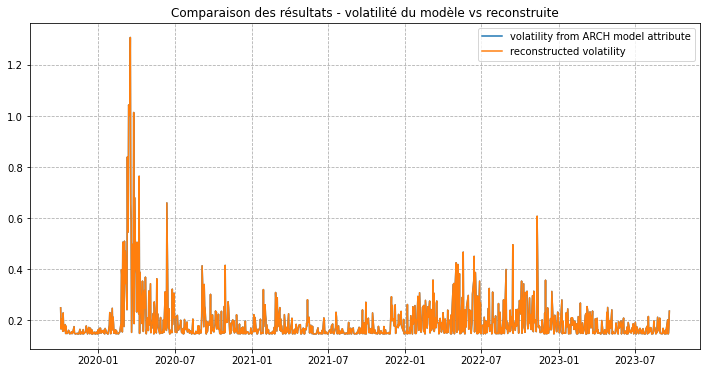

In [66]:
plt.figure(figsize=(12,6)) 
plt.plot(df_mod_vol.tail(1000)*np.sqrt(252), label="volatility from ARCH model attribute")
plt.plot(arch_vol.tail(1000), label="reconstructed volatility")
plt.title("Comparaison des résultats - volatilité du modèle vs reconstruite")
plt.legend()
plt.grid(linestyle="--")

Naturellement, il n'y a aucune différence !

Au delà de l'estimation des modèles, le module arch fourni des méthodes intéressantes pour effectuer des prévisions ou bien transformer en graphique les estimations du modèle :

**Graphiques :**

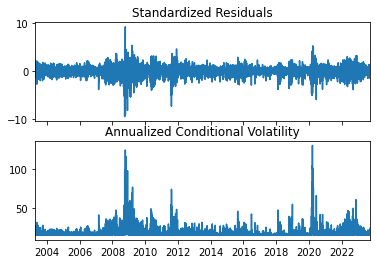

In [157]:
model.plot(annualize="D");

**Prévisions de volatilité :**

Le module fourni plusieurs méthodes de prévision :
1. Analytical (par défaut)
2. Simulation
3. Bootstrap 

> Les prévisions sont effectuées par récursivité vers l'avant (forward recursion). Cela fonctionne bien pour des modèles linéaires, mais n'est pas applicable pour ceux qui sont non linéaires et qui n'ont pas de solution analytique pour la volatilité multi-période. De plus, toute les méthodes ne sont pas applicables à tous les horizons de prévision.


Essayons et comparons les résultats des différentes méthodes :

***Méthode Analytique :***

In [67]:
HORIZON = 10

analytical_cm_arch1 = model.forecast(horizon=HORIZON, reindex=False)
analytical_fcst_vol = np.sqrt(analytical_cm_arch1.variance.tail(1).T)/100*np.sqrt(252)
analytical_fcst_vol.T

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
date,,,,,,,,,,
2023-09-22,0.149603,0.177821,0.189412,0.194519,0.196827,0.197881,0.198365,0.198587,0.19869,0.198737


Les colonnes représentent les prévisions de **variance** pour chaque incrément dans le future.
- h.01 pour la prévision à un jour
- h.02 pour la prévision à deux jours
- et ainsi de suite jusqu'au dernier jours de l'horizon choisi


***Méthode par Simulations :***

In [68]:
simulation_cm_arch1 = model.forecast(horizon=HORIZON, method="simulation", reindex=False)
simulation_fcst_vol = np.sqrt(simulation_cm_arch1.variance.tail(1).T)/100*np.sqrt(252)
simulation_fcst_vol.T

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
date,,,,,,,,,,
2023-09-22,0.149603,0.17837,0.189484,0.194238,0.198794,0.20093,0.197979,0.199485,0.199953,0.200717


***Méthode par Bootstrap :***

In [69]:
bootstrap_cm_arch1 = model.forecast(horizon=HORIZON, method="bootstrap", reindex=False)
bootstrap_fcst_vol = np.sqrt(bootstrap_cm_arch1.variance.tail(1).T)/100*np.sqrt(252)
bootstrap_fcst_vol.T

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
date,,,,,,,,,,
2023-09-22,0.149603,0.17563,0.187621,0.193745,0.185862,0.189405,0.190237,0.192184,0.19039,0.202372


***Comparaison des résultats***

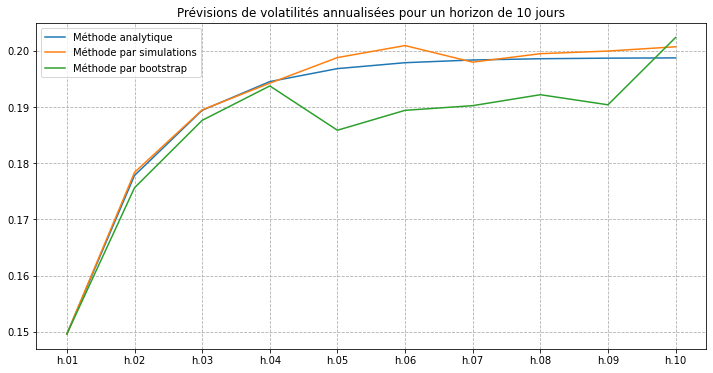

In [70]:
plt.figure(figsize=(12,6)) 
plt.plot(analytical_fcst_vol, label="Méthode analytique")
plt.plot(simulation_fcst_vol, label="Méthode par simulations")
plt.plot(bootstrap_fcst_vol, label="Méthode par bootstrap")
plt.title(f"Prévisions de volatilités annualisées pour un horizon de {HORIZON} jours")
plt.legend()
plt.grid(linestyle="--")

Essayons de voir si nous pouvons améliorer notre modélisation !

Nous allons tester plusieurs lags et garder le meilleur modèle (c'est à dire celui qui minimise le critère de Bayes). Pour comparer nos modèles, nous allons garder en mémoire la statistique de log-likelihood.

In [167]:
results = dict()

for lag in range(1,30):
    current_model = arch_model(daily_returns*100, mean="Constant", vol="ARCH", p=lag)
    current_fit = current_model.fit()
    results.update({
        str(lag):{
            "log-likelihood":current_fit._loglikelihood,
            "aic":current_fit.aic,
            "bic":current_fit.bic
        }
    })

df_results = pd.DataFrame().from_dict(results, orient='index')

Iteration:      1,   Func. Count:      5,   Neg. LLF: 35392.99245053025
Iteration:      2,   Func. Count:     14,   Neg. LLF: 11550.413714831875
Iteration:      3,   Func. Count:     21,   Neg. LLF: 7826.768761930634
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7733.938967629658
Iteration:      5,   Func. Count:     30,   Neg. LLF: 7733.934501455618
Iteration:      6,   Func. Count:     34,   Neg. LLF: 7733.934454453287
Iteration:      7,   Func. Count:     38,   Neg. LLF: 7733.934453721471
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7733.934453721471
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 43073.74802544525
Iteration:      2,   Func. Count:     16,   Neg. LLF: 12157.279798473344
Iteration:      3,   Func. Count:     24,   Neg. LLF: 7771.264479332045
Iteration:      4,   Func. Count:     30,   Neg. LLF: 7673.823688763522

Iteration:      8,   Func. Count:    105,   Neg. LLF: 7588.283499047773
Iteration:      9,   Func. Count:    118,   Neg. LLF: 7432.812574390107
Iteration:     10,   Func. Count:    131,   Neg. LLF: 7257.210106979571
Iteration:     11,   Func. Count:    144,   Neg. LLF: 6936.201536189261
Iteration:     12,   Func. Count:    157,   Neg. LLF: 6915.773067736036
Iteration:     13,   Func. Count:    170,   Neg. LLF: 6926.644167290295
Iteration:     14,   Func. Count:    183,   Neg. LLF: 6969.42263521206
Iteration:     15,   Func. Count:    196,   Neg. LLF: 6828.847419334954
Iteration:     16,   Func. Count:    208,   Neg. LLF: 6828.788122849659
Iteration:     17,   Func. Count:    219,   Neg. LLF: 6828.7881143065915
Iteration:     18,   Func. Count:    229,   Neg. LLF: 6828.78811430663
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6828.7881143065915
            Iterations: 18
            Function evaluations: 229
            Gradient evaluations: 1

Iteration:      4,   Func. Count:     72,   Neg. LLF: 146944.94238630222
Iteration:      5,   Func. Count:     90,   Neg. LLF: 8835.452155759442
Iteration:      6,   Func. Count:    109,   Neg. LLF: 11012.179063049183
Iteration:      7,   Func. Count:    127,   Neg. LLF: 9938.259321018868
Iteration:      8,   Func. Count:    145,   Neg. LLF: 8858.442108567242
Iteration:      9,   Func. Count:    163,   Neg. LLF: 8228.478669244432
Iteration:     10,   Func. Count:    180,   Neg. LLF: 7619.687548970289
Iteration:     11,   Func. Count:    198,   Neg. LLF: 7110.311059237894
Iteration:     12,   Func. Count:    216,   Neg. LLF: 7084.155664784454
Iteration:     13,   Func. Count:    234,   Neg. LLF: 7045.261817793276
Iteration:     14,   Func. Count:    251,   Neg. LLF: 7295.909666186093
Iteration:     15,   Func. Count:    269,   Neg. LLF: 7049.403604455267
Iteration:     16,   Func. Count:    286,   Neg. LLF: 7086.733438423712
Iteration:     17,   Func. Count:    304,   Neg. LLF: 6997.636

Iteration:     20,   Func. Count:    413,   Neg. LLF: 6942.151609977995
Iteration:     21,   Func. Count:    433,   Neg. LLF: 6910.878653703005
Iteration:     22,   Func. Count:    454,   Neg. LLF: 6906.201647284245
Iteration:     23,   Func. Count:    475,   Neg. LLF: 6857.568015370116
Iteration:     24,   Func. Count:    495,   Neg. LLF: 6891.440110910489
Iteration:     25,   Func. Count:    516,   Neg. LLF: 6836.290397652693
Iteration:     26,   Func. Count:    537,   Neg. LLF: 6820.397716580363
Iteration:     27,   Func. Count:    558,   Neg. LLF: 6820.937581447449
Iteration:     28,   Func. Count:    578,   Neg. LLF: 6797.445041886805
Iteration:     29,   Func. Count:    598,   Neg. LLF: 6839.836732289379
Iteration:     30,   Func. Count:    619,   Neg. LLF: 6797.1556168607785
Iteration:     31,   Func. Count:    639,   Neg. LLF: 6797.098912648789
Iteration:     32,   Func. Count:    659,   Neg. LLF: 6798.755472145005
Iteration:     33,   Func. Count:    679,   Neg. LLF: 6797.0728

Iteration:     15,   Func. Count:    355,   Neg. LLF: 7721.307002402741
Iteration:     16,   Func. Count:    378,   Neg. LLF: 7023.794482843481
Iteration:     17,   Func. Count:    401,   Neg. LLF: 7247.058103797487
Iteration:     18,   Func. Count:    425,   Neg. LLF: 6961.504938833579
Iteration:     19,   Func. Count:    448,   Neg. LLF: 6962.942422692251
Iteration:     20,   Func. Count:    472,   Neg. LLF: 6943.744301856863
Iteration:     21,   Func. Count:    496,   Neg. LLF: 6968.256470101871
Iteration:     22,   Func. Count:    520,   Neg. LLF: 6836.584207138074
Iteration:     23,   Func. Count:    543,   Neg. LLF: 7040.282647566695
Iteration:     24,   Func. Count:    567,   Neg. LLF: 6939.404197357491
Iteration:     25,   Func. Count:    591,   Neg. LLF: 6833.690240630833
Iteration:     26,   Func. Count:    614,   Neg. LLF: 6860.089904456685
Iteration:     27,   Func. Count:    638,   Neg. LLF: 6809.38698819305
Iteration:     28,   Func. Count:    661,   Neg. LLF: 6813.440938

Iteration:     35,   Func. Count:    894,   Neg. LLF: 6794.321128828594
Iteration:     36,   Func. Count:    918,   Neg. LLF: 6794.304248866093
Iteration:     37,   Func. Count:    942,   Neg. LLF: 6799.544560633359
Iteration:     38,   Func. Count:    968,   Neg. LLF: 6796.88953984094
Iteration:     39,   Func. Count:    994,   Neg. LLF: 6797.019443377605
Iteration:     40,   Func. Count: 1.02e+03,   Neg. LLF: 6794.31874197172
Iteration:     41,   Func. Count: 1.04e+03,   Neg. LLF: 6794.310463070453
Iteration:     42,   Func. Count: 1.07e+03,   Neg. LLF: 6794.279327351111
Iteration:     43,   Func. Count: 1.1e+03,   Neg. LLF: 6794.280427301145
Iteration:     44,   Func. Count: 1.12e+03,   Neg. LLF: 6794.278756572548
Iteration:     45,   Func. Count: 1.14e+03,   Neg. LLF: 6794.277913115604
Iteration:     46,   Func. Count: 1.17e+03,   Neg. LLF: 6794.277128848593
Iteration:     47,   Func. Count: 1.19e+03,   Neg. LLF: 6794.277126603527
Iteration:     48,   Func. Count: 1.22e+03,   Neg. 

Iteration:      8,   Func. Count:    230,   Neg. LLF: 9103.68686068003
Iteration:      9,   Func. Count:    259,   Neg. LLF: 7872.90805332495
Iteration:     10,   Func. Count:    287,   Neg. LLF: 9251.255139705234
Iteration:     11,   Func. Count:    315,   Neg. LLF: 7924.496651239311
Iteration:     12,   Func. Count:    344,   Neg. LLF: 7389.7039801404135
Iteration:     13,   Func. Count:    372,   Neg. LLF: 7417.215363474873
Iteration:     14,   Func. Count:    400,   Neg. LLF: 7165.863923374489
Iteration:     15,   Func. Count:    428,   Neg. LLF: 7115.499771932439
Iteration:     16,   Func. Count:    456,   Neg. LLF: 7192.228756338165
Iteration:     17,   Func. Count:    485,   Neg. LLF: 7057.928176593896
Iteration:     18,   Func. Count:    513,   Neg. LLF: 6960.777436420809
Iteration:     19,   Func. Count:    542,   Neg. LLF: 7082.374163286213
Iteration:     20,   Func. Count:    570,   Neg. LLF: 6993.509024328445
Iteration:     21,   Func. Count:    599,   Neg. LLF: 7043.096647

Iteration:     25,   Func. Count:    762,   Neg. LLF: 6886.257937958562
Iteration:     26,   Func. Count:    792,   Neg. LLF: 6846.982482710687
Iteration:     27,   Func. Count:    822,   Neg. LLF: 6844.284117458364
Iteration:     28,   Func. Count:    852,   Neg. LLF: 6810.906941480669
Iteration:     29,   Func. Count:    882,   Neg. LLF: 6870.232991109597
Iteration:     30,   Func. Count:    913,   Neg. LLF: 6980.835534676465
Iteration:     31,   Func. Count:    944,   Neg. LLF: 6904.839106192682
Iteration:     32,   Func. Count:    975,   Neg. LLF: 6809.345118061308
Iteration:     33,   Func. Count:  1e+03,   Neg. LLF: 6812.796457420969
Iteration:     34,   Func. Count: 1.04e+03,   Neg. LLF: 6796.899427410126
Iteration:     35,   Func. Count: 1.06e+03,   Neg. LLF: 6798.32193349256
Iteration:     36,   Func. Count: 1.1e+03,   Neg. LLF: 6803.897333267314
Iteration:     37,   Func. Count: 1.12e+03,   Neg. LLF: 6797.038571561065
Iteration:     38,   Func. Count: 1.16e+03,   Neg. LLF: 67

Iteration:     38,   Func. Count: 1.23e+03,   Neg. LLF: 6799.878794232127
Iteration:     39,   Func. Count: 1.26e+03,   Neg. LLF: 6820.241433193922
Iteration:     40,   Func. Count: 1.3e+03,   Neg. LLF: 6791.37724386775
Iteration:     41,   Func. Count: 1.33e+03,   Neg. LLF: 6793.568368440767
Iteration:     42,   Func. Count: 1.36e+03,   Neg. LLF: 6791.567581038903
Iteration:     43,   Func. Count: 1.39e+03,   Neg. LLF: 6793.1338754179
Iteration:     44,   Func. Count: 1.42e+03,   Neg. LLF: 6791.945622196957
Iteration:     45,   Func. Count: 1.46e+03,   Neg. LLF: 6790.424537500732
Iteration:     46,   Func. Count: 1.49e+03,   Neg. LLF: 6790.0907688483585
Iteration:     47,   Func. Count: 1.52e+03,   Neg. LLF: 6790.08603087847
Iteration:     48,   Func. Count: 1.55e+03,   Neg. LLF: 6790.085839836272
Iteration:     49,   Func. Count: 1.58e+03,   Neg. LLF: 6790.085794489027
Iteration:     50,   Func. Count: 1.61e+03,   Neg. LLF: 6790.085793597604
Optimization terminated successfully    (E

In [171]:
print(df_results.sort_values("bic", ascending=True))

    log-likelihood           aic           bic
11    -6801.747039  13629.494079  13714.579116
10    -6808.777876  13641.555752  13720.095787
12    -6801.607978  13631.215955  13722.845996
9     -6816.294466  13654.588932  13726.583964
13    -6799.369597  13628.739193  13726.914237
14    -6798.325287  13628.650575  13733.370621
15    -6798.047380  13630.094761  13741.359810
8     -6828.788114  13677.576229  13743.026258
16    -6797.063953  13630.127907  13747.937959
17    -6796.599941  13631.199882  13755.554937
18    -6796.436005  13632.872009  13763.772067
7     -6845.345524  13708.691048  13767.596074
19    -6794.277690  13630.555380  13768.000441
20    -6794.277126  13632.554252  13776.544316
21    -6794.277126  13634.554252  13785.089318
22    -6791.694920  13631.389840  13788.469909
23    -6790.770834  13631.541667  13795.166739
6     -6863.677748  13743.355496  13795.715519
24    -6790.614200  13633.228400  13803.398475
25    -6790.614200  13635.228400  13811.943478
26    -6790.6

Ces résultats nous permettent de voire que c'est avec un lag de 11 qu'on optimise le critère de Bayes. Nous allons donc estimer un modèle ARCH(11) et le comparer avec les modèles précedents.


<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black"> 
<b>Pourquoi préférer le critère de Bayes plutôt que le critère de vraisemblance pour choisir notre modèle ?</b>
<br><br>
&#129504;
Parce que le critère de Bayes (mais c'est aussi vrai pour le critère d'Akaike), va pénaliser le modèle à mesure que l'on va rajouter des variables. Ainsi il va favoriser des modèles plus généralisés et permet d'eviter l'overfitting. D'ailleurs, on peut voir dans les résultats ci-dessus qu'on améliore constamment le critère de vraisemblance à mesure qu'on rajoute des lags, pourtant passé un certains nombre, la plupart d'entre eux est non significatif avec un intervalle de confiance de 5%.
</p>

In [71]:
am11 = arch_model(daily_returns*100, mean="Constant", vol="ARCH", p=11)
model11 = am11.fit()
df_mod11_vol = pd.DataFrame(model11._volatility, index=arch_vol.index)*np.sqrt(252)
print(model11.summary())

Iteration:      1,   Func. Count:     15,   Neg. LLF: 87760.8628160359
Iteration:      2,   Func. Count:     34,   Neg. LLF: 6577287.833032029
Iteration:      3,   Func. Count:     49,   Neg. LLF: 74795.29613475267
Iteration:      4,   Func. Count:     64,   Neg. LLF: 7556.372077541001
Iteration:      5,   Func. Count:     80,   Neg. LLF: 15830.013585504497
Iteration:      6,   Func. Count:     95,   Neg. LLF: 8020.003745370384
Iteration:      7,   Func. Count:    111,   Neg. LLF: 8684.031043478306
Iteration:      8,   Func. Count:    127,   Neg. LLF: 10801.7176841979
Iteration:      9,   Func. Count:    143,   Neg. LLF: 7352.475419150308
Iteration:     10,   Func. Count:    158,   Neg. LLF: 7438.082208082565
Iteration:     11,   Func. Count:    174,   Neg. LLF: 7164.985506182004
Iteration:     12,   Func. Count:    190,   Neg. LLF: 7041.736123395851
Iteration:     13,   Func. Count:    206,   Neg. LLF: 6994.16382535648
Iteration:     14,   Func. Count:    222,   Neg. LLF: 6968.2031846

**Points saillants :**

- Tous nos paramètres sont significatifs (ce qui est plutôt une bonne chose).
- Avec ce modèle, omega vaut 7% (annualisé), tandis qu'avec l'ARCH(1) il vallait 14.6%.
- Notre modèle étant plus complexe, on observe qu'il a besoin de plus d'itération pour parvenir à la solution optimale.

In [72]:
cm_arch11_lt_vol = np.sqrt(model11.params[1]/(1 - np.sum(model11.params[2:13]))) * np.sqrt(252)
print(f"Volatilité de long terme de notre modèle Arch(11) : {cm_arch11_lt_vol/100:.2%}")

Volatilité de long terme de notre modèle Arch(11) : 17.74%


In [73]:
HORIZON = 10

analytical_cm_arch11 = model11.forecast(horizon=HORIZON, reindex=False)
analytical_fcst_arch11_vol = np.sqrt(analytical_cm_arch11.variance.tail(1).T)/100*np.sqrt(252)
analytical_fcst_arch11_vol.T

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
date,,,,,,,,,,
2023-09-22,0.151208,0.147534,0.160164,0.149102,0.157851,0.155815,0.15824,0.159125,0.16388,0.16352


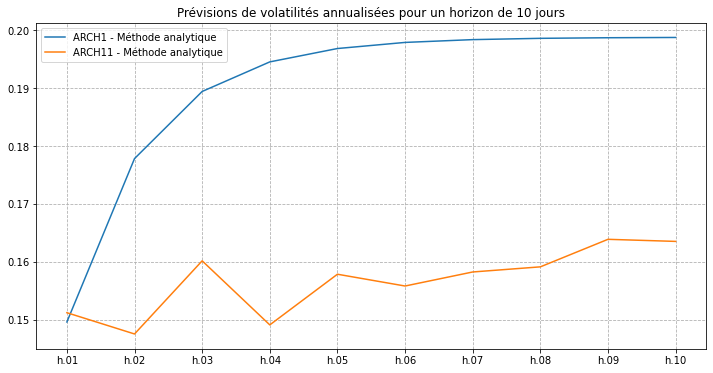

In [74]:
plt.figure(figsize=(12,6)) 
plt.plot(analytical_fcst_vol, label="ARCH1 - Méthode analytique")
plt.plot(analytical_fcst_arch11_vol, label="ARCH11 - Méthode analytique")
plt.title(f"Prévisions de volatilités annualisées pour un horizon de {HORIZON} jours")
plt.legend()
plt.grid(linestyle="--")

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black"> 
&#129504;
    <b>Ce graphique montre plusieurs choses intéressantes :</b>
<br>
    - Le modèle ARCH1 est trop simpliste et ses prévisions sont irréalistes
<br>    
    - C'est un modèle paramétrique, assez simple à interpréter
<br>    
    - Mais comme tout modèle paramétrique, les résultats seront sensibles (très) aux paramétres choisis
<br>
    - A l'inverse, le modèle ARCH11 est assez réaliste, mais moins simple à interpréter
<br>
    - Cependant, il a besoin de nombreuses données passées pour être réaliste
</p>

&#x1F447;
**Nous verrons plus loin comment les modèles de type GARCH peuvent répondre à ces inconvénients (moins paramétriques et plus réalistes)** 

Comparons ci-dessous le modèle ARCH11 à nos différents modèles (EWMA et EWMA récursif).

In [75]:
ewma11 = daily_returns.rolling(11).apply(lambda x: ewma(x, 0.94, 11)) * np.sqrt(252)
rec_ewma = np.sqrt(recursive_variance(daily_returns, 0.94)) * np.sqrt(252)
sma11 = daily_returns.rolling(11).apply(lambda x: sma(x, 11)) * np.sqrt(252)

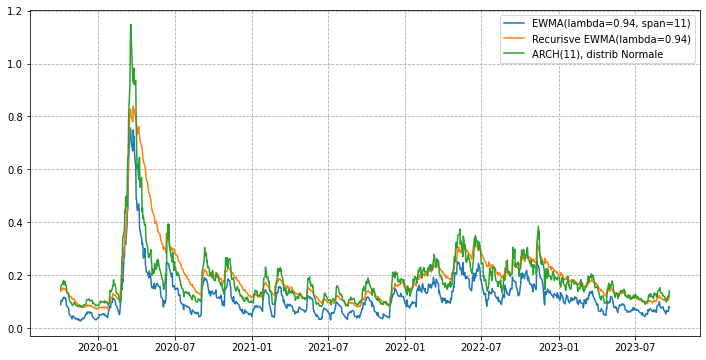

In [76]:
plt.figure(figsize=(12,6))
plt.plot(ewma11.tail(1000), label="EWMA(lambda=0.94, span=11)")
plt.plot(rec_ewma.tail(1000), label="Recurisve EWMA(lambda=0.94)")
plt.plot(df_mod11_vol.tail(1000)/100., label="ARCH(11), distrib Normale")
plt.legend()
plt.grid(linestyle="--")

**Points saillants :**
- Les variations du modèle ARCH11 sont très proches de celles du modèle EWMA. C'est normal, dans les deux cas, on utilise les 11 derniers jours, mais dans le modèle ARCH les coéfficients à appliquer ont été estimés, alors que pour l'EWMA, ils décroissent en fonction de notre paramètre $\lambda$.
- Le modèle EWMA récursif semble plus "linéaire" et moins volatile, par contre il suit parfaitement le tracé de notre modèle ARCH11.
- Les variations du modèle EWMA semblent correctes, mais toujours sous-estimer la variance inconditionnelle de long terme.

Comparons maintenant les données empiriques aux prévisions de notre modèle ARCH11 :

In [77]:
arch11_fcst_10days = model11.forecast(horizon=HORIZON, start="2023-09-11", reindex=False)
arch11_vol_10days = np.sqrt(arch11_fcst_10days.variance[arch11_fcst_10days.variance.index == "2023-09-11"].T)/100*np.sqrt(252)
arch11_vol_10days.index = ewma11.index[-HORIZON:] # remplacement des horizons par dates

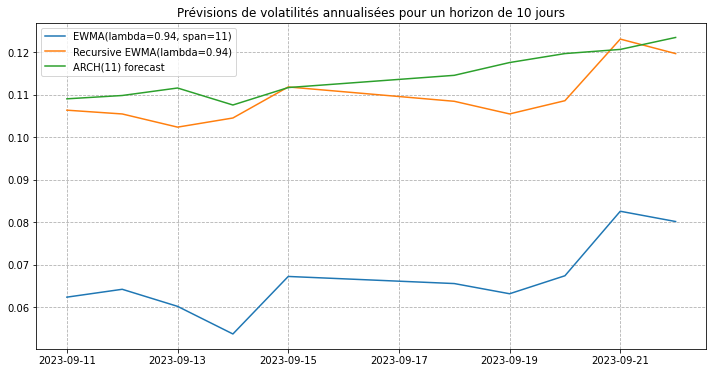

In [78]:
plt.figure(figsize=(12,6))
plt.plot(ewma11.tail(HORIZON), label="EWMA(lambda=0.94, span=11)")
plt.plot(rec_ewma.tail(HORIZON), label="Recursive EWMA(lambda=0.94)")
plt.plot(arch11_vol_10days, label="ARCH(11) forecast")
plt.legend()
plt.title(f"Prévisions de volatilités annualisées pour un horizon de {HORIZON} jours")
plt.grid(linestyle="--")

**Points saillants :**
- Les prévisions faites par le modèles ARCH11 sont proches de la réalité en termes de variations.
- Comme montré au dessus, la volatilité moyenne selon le modèle EWMA est plus faible que pour le modèle ARCH11 et l'EWMA récursive.

**Estimation d'un modèle GARCH(1,1)**

Un modèle GARCH(p,q) se définit comme suit (en reprenant les conventions vues précédemment) :

Le cas le plus simple étant celui du GARCH(1,1) où :

$\sigma_{t}^2 = \alpha_{0} + \alpha_{1}\epsilon_{t-1}^2 +\alpha_{2}\sigma_{t-1}^2$

On peut réécrire le modèle selon les termes (usuels) utilisés par notre module python :

$\sigma_{t}^2 = \omega + \alpha\epsilon_{t-1}^2 +\beta\sigma_{t-1}^2$

Si on généralise cette modélisation, on obtient la forme suivante :

$\sigma_{t}^2 = \omega + \sum_{i=1}^{p}\alpha_{i}\epsilon_{t-i}^2 + \sum_{j=1}^{q}\beta_{j}\sigma_{t-j}^2$

avec les contraintes suivantes, on s'assure de la variance inconditionnelle sera finie positive :

- $\omega>0$
- $\alpha+\beta < 1$

et avec cette dernière contrainte, on s'assure que la variance conditionnelle sera toujours positive :
- $\alpha,\beta \geq 0$




***Arrêtons nous un instant ici, et décomposons cette nouvelle équation !***

- $\alpha$ mesure le degré de réaction de la volatilité à un choc de marché. Lorsque alpha est relativement large (au dessus de 0.1) alors la volatilité conditionnelle est sensible aux évènements de marché.
- $\beta$ est un paramètre de retard qui va mesurer la persistance de la volatilité conditionnelle indépendamment de tout ce qui se passe sur le marché. Lorsque beta est relativement élevé (c'est à dire supérieur à 0.9) cela veut dire que la volatilité va mettre plus de temps à revenir à la normale après un choc de marché.
- la somme ($\alpha$ + $\beta$) constitue un ratio de convergence de la volatilité conditionnelle vers sa moyenne de long terme. Plus ce ratio est élevé, plus la structure par terme de la volatilité est plate.
- $\omega$ est la constante du modèle GARCH. Prise en compte avec les autres paramètres du modèle, elle permet de calculer la volatilité de long terme d'un actif financier. Cela représente la volatilité inconditionnelle d'un actif financier dans la modélisation GARCH.

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">
&#x1F4A1;
<b>Expression de la volatilité de long terme d'un modèle GARCH :</b>
    <br>
    <br>
En l'absence de chocs, la variance devrait converger vers sa moyenne de long terme dont la valeur est $\bar{\sigma}^2$. Dans ce cas on peut considérer que $\sigma^2_{t} = \bar{\sigma}^2$ pour tout t. De plus, cette modélisation étant symétrique (les rendements négatifs sont traités de la même manière que les rendements positifs), on peut également considérer que $E(\epsilon^2_{t-1}) = \sigma^2_{t-1}$.
    <br>
    <br>
Cela nous permet de réécrire notre modèle initiale comme suit :
    <br>
    <br>
$\bar{\sigma}^2 = \omega + \alpha\bar{\sigma}^2 + \beta\bar{\sigma}^2$
    <br>
    <br>
$\bar{\sigma}^2(1 - (\alpha + \beta)) = \omega$ 
    <br>
    <br>
Et d'exprimer la variance "inconditionnelle" de long terme comme :
    <br>
    <br>
$\bar{\sigma}^2 = \frac{\omega}{1 - (\alpha + \beta)}$    
<p>

**Estimation de notre modèle Garch(1,1)**

In [79]:
cm_garch = arch_model(daily_returns*100)
model_cm_garch = cm_garch.fit()
print(model_cm_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1801785626.4492054
Iteration:      2,   Func. Count:     15,   Neg. LLF: 946342455.9460164
Iteration:      3,   Func. Count:     22,   Neg. LLF: 9569.923433883538
Iteration:      4,   Func. Count:     29,   Neg. LLF: 6944.780560977972
Iteration:      5,   Func. Count:     35,   Neg. LLF: 6820.4612305193095
Iteration:      6,   Func. Count:     41,   Neg. LLF: 6980.0342873016125
Iteration:      7,   Func. Count:     47,   Neg. LLF: 6804.676585605939
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6804.670463722012
Iteration:      9,   Func. Count:     57,   Neg. LLF: 6804.670385467014
Iteration:     10,   Func. Count:     62,   Neg. LLF: 6804.670383094972
Iteration:     11,   Func. Count:     66,   Neg. LLF: 6804.6703830923825
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6804.670383094972
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations

Tous nos paramètres sont significatifs !

**Estimation de la volatilité de long terme**

In [80]:
garch_lt_vol = np.sqrt(model_cm_garch.params[1] / (1 - (model_cm_garch.params[2] + model_cm_garch.params[3])))*np.sqrt(252)
print(f"Volatilité de long terme : {garch_lt_vol/100:.2%}")

Volatilité de long terme : 17.07%


Comparons maintenant nos modèles de volatilité :

In [81]:
df_garch_vol = pd.DataFrame(model_cm_garch._volatility, index=daily_returns.index)*np.sqrt(252)

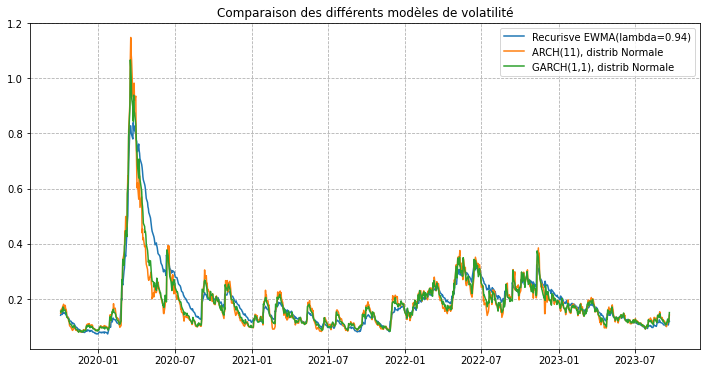

In [82]:
plt.figure(figsize=(12,6))
plt.plot(rec_ewma.tail(1000), label="Recurisve EWMA(lambda=0.94)")
plt.plot(df_mod11_vol.tail(1000)/100., label="ARCH(11), distrib Normale")
plt.plot(df_garch_vol.tail(1000)/100., label="GARCH(1,1), distrib Normale")
plt.legend()
plt.title("Comparaison des différents modèles de volatilité")
plt.grid(linestyle="--")

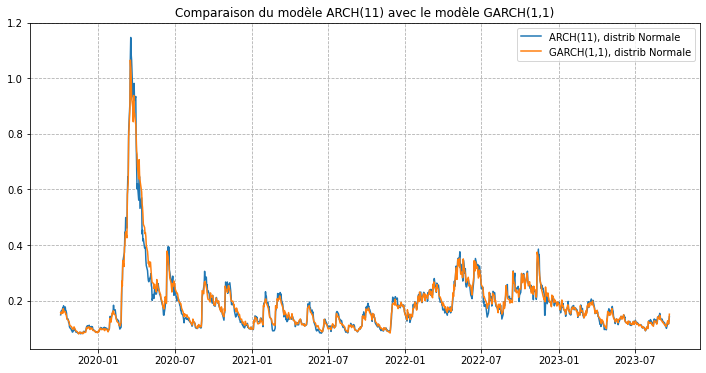

In [83]:
plt.figure(figsize=(12,6))
plt.plot(df_mod11_vol.tail(1000)/100., label="ARCH(11), distrib Normale")
plt.plot(df_garch_vol.tail(1000)/100., label="GARCH(1,1), distrib Normale")
plt.legend()
plt.title("Comparaison du modèle ARCH(11) avec le modèle GARCH(1,1)")
plt.grid(linestyle="--")

**Points saillants :**
- Notre modèle GARCH(1,1) donne des résultats très similaires à ceux du modèle ARCH(11), pourtant nous n'avons pas eu à effectuer une "optimisation paramétrique" comme nous l'avion fait pour le modèle ARCH(11) !!!
- La modélisation GARCH permet bien de capter les clusters de volatilité.
- Les volatilités de long terme estimées à partir des deux modèles restent proches (17.74% pour l'ARCH(11) vs 17.07% pour le GARCH(1,1)).

In [84]:
analytical_cm_garch = model_cm_garch.forecast(horizon=HORIZON, reindex=False)
analytical_garch_fcst_vol = np.sqrt(analytical_cm_garch.variance.tail(1).T)/100*np.sqrt(252)
analytical_garch_fcst_vol.T

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
date,,,,,,,,,,
2023-09-22,0.142467,0.143132,0.143781,0.144413,0.145028,0.145628,0.146212,0.146782,0.147337,0.147878


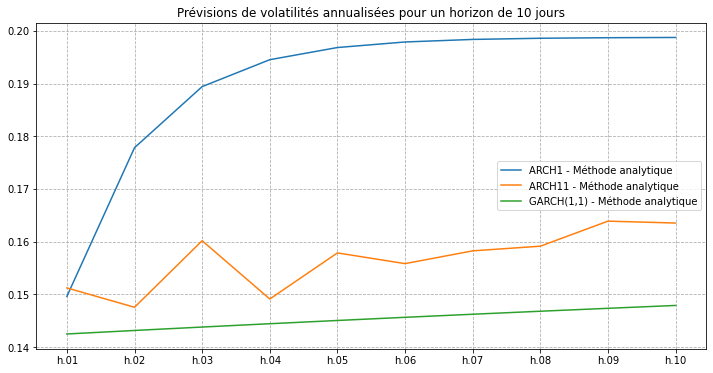

In [85]:
plt.figure(figsize=(12,6)) 
plt.plot(analytical_fcst_vol, label="ARCH1 - Méthode analytique")
plt.plot(analytical_fcst_arch11_vol, label="ARCH11 - Méthode analytique")
plt.plot(analytical_garch_fcst_vol, label="GARCH(1,1) - Méthode analytique")
plt.title(f"Prévisions de volatilités annualisées pour un horizon de {HORIZON} jours")
plt.legend()
plt.grid(linestyle="--")

&#x1F4A1;
**Note :**
Il est difficile de comparer deux séries de volatilité (variance) à un instant t tant les différences de modélisations vont produire à travers les séries temporelles des résultats différents (notamment à cause de la récursivité). C'est pourquoi je préfère comparer les résultats en variation, en faisant abstraction du points de départ de chaque série.

<div style="text-align:justify;">
Bien que cette modélisation rende bien compte du phénomène de cluster, <b>elle ne tient pas compte du "leverage effect"</b> qui est si important pour modéliser la volatilité des actifs liquides. Comme mentionné plus haut, en l'état, la réponse à une variation à la hausse et la même qu'une variation à la baisse, ce qui ne reflète pas la réalité des marchés.
</div>    
    
A titre d'information, vous trouverez ci-dessous une liste (non exhaustive) de modélisation GARCH permettant de prendre en compte le "leverage effect" :

   - A-GARCH : asymetric-GARCH
   - APARCH : asymetric power GARCH
   - GJR-GARCH : threshold GARCH
   - E-GARCH : exponential GARCH
    
    
Dans les lignes qui vont suivre, nous étudirons la modélisation GJR-GARCH.

4. <a id='gjr-garch'>GJR-GARCH</a>

Cette modélisation permet donc de rajouter un paramètre permettant d'estimer l'effet de levier sur les rendements négatifs, et de produire un comportement asymétrique lors des stress de marchés.

La modèle s'écrit de la manière suivante :

$\sigma_{t}^2 = \omega + \alpha \epsilon_{t-1}^2 + \gamma 1_{\left \{ \epsilon_{t-1} < 0 \right \}} \epsilon_{t-1}^2+ \beta \sigma_{t-1}^2$

Cette équation a une nouveauté :

$\gamma 1_{\left \{ \epsilon_{t-1} < 0 \right \}} \epsilon_{t-1}^2$

Qui implique qu'en présence de rendements négatifs, l'innovation est augmentée d'un facteur d'elle même. Comme $\epsilon_{t-1}$ est au carré, l'innovation est forcément positive, et d'autant plus élevée que le rendement est important, ce qui va traduire ce phénomène d'asymétrie des rendements lors des phases de baisses des marchés.

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">
&#x1F4A1;
<b>Expression de la volatilité de long terme d'un modèle GJR-GARCH :</b>
    <br>
    <br>
En l'absence de chocs, la variance devrait converger vers sa moyenne de long terme dont la valeur est $\bar{\sigma}^2$. Dans ce cas on peut considérer que $\sigma^2_{t} = \bar{\sigma}^2$ pour tout t. De plus, dans le cadre d'un modèle symétrique, nous avons posé que $E(\epsilon_{t}^2)=\sigma_{t}^2$, et on peut également écrire que $E(1_{\left \{ \epsilon_{t-1} < 0 \right \}} \epsilon_{t-1}^2) = \frac{1}{2} \sigma_{t}^2$.
    <br>
    <br>
Cela nous permet de réécrire notre modèle initiale comme suit :
    <br>
    <br>
$\bar{\sigma}^2 = \omega + \alpha\bar{\sigma}^2 + \frac{1}{2} \gamma \bar{\sigma}^2 + \beta \bar{\sigma}^2$
    <br>
    <br>
$\bar{\sigma}^2 - \alpha\bar{\sigma}^2 - \frac{1}{2} \gamma \bar{\sigma}^2 - \beta \bar{\sigma}^2 = \omega$
    <br>
    <br>
$\bar{\sigma}^2(1 - (\alpha + \frac{1}{2} \gamma + \beta)) = \omega$ 
    <br>
    <br>
Et d'exprimer la variance "inconditionnelle" de long terme comme :
    <br>
    <br>
$\bar{\sigma}^2 = \frac{\omega}{1 - (\alpha + \frac{1}{2} \gamma + \beta)}$    
<p>

In [86]:
gjr_cm_garch = arch_model(daily_returns*100, p=1, o=1, q=1)
model_gjr_cm_garch = gjr_cm_garch.fit()
print(model_gjr_cm_garch.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 27971375408.622284
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2865295256.1788797
Iteration:      3,   Func. Count:     25,   Neg. LLF: 21933029.742022164
Iteration:      4,   Func. Count:     34,   Neg. LLF: 6910.8694885639725
Iteration:      5,   Func. Count:     41,   Neg. LLF: 7335.886599026733
Iteration:      6,   Func. Count:     48,   Neg. LLF: 6742.028626363679
Iteration:      7,   Func. Count:     56,   Neg. LLF: 6720.729949356556
Iteration:      8,   Func. Count:     63,   Neg. LLF: 13313.759344754602
Iteration:      9,   Func. Count:     72,   Neg. LLF: 6719.065208060238
Iteration:     10,   Func. Count:     78,   Neg. LLF: 6719.065059278568
Iteration:     11,   Func. Count:     84,   Neg. LLF: 6719.065058674007
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6719.065058674007
            Iterations: 11
            Function evaluations: 84
            Gradient evaluation

**Estimation de la volatilité de long terme**

In [87]:
gjr_garch_lt_vol = np.sqrt(model_gjr_cm_garch.params[1] / (1 - (model_gjr_cm_garch.params[2] + model_gjr_cm_garch.params[3]*0.5 + model_gjr_cm_garch.params[4])))*np.sqrt(252)
print(f"Volatilité de long terme : {gjr_garch_lt_vol/100:.2%}")

Volatilité de long terme : 15.80%


In [88]:
df_gjr_garch_vol = pd.DataFrame(model_gjr_cm_garch._volatility, index=daily_returns.index)*np.sqrt(252)

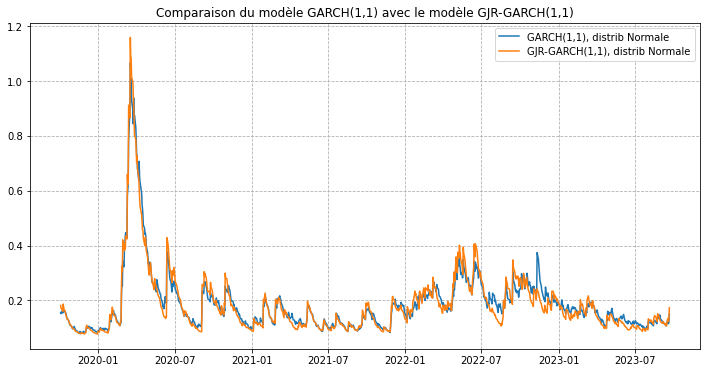

In [89]:
plt.figure(figsize=(12,6))
plt.plot(df_garch_vol.tail(1000)/100., label="GARCH(1,1), distrib Normale")
plt.plot(df_gjr_garch_vol.tail(1000)/100., label="GJR-GARCH(1,1), distrib Normale")
plt.legend()
plt.title("Comparaison du modèle GARCH(1,1) avec le modèle GJR-GARCH(1,1)")
plt.grid(linestyle="--")

**Points saillants :**
- la modélisation gjr-garch donne des résultats similaires à ceux du modèle garch.
- la prise en compte du "leverage effect" est traduite par le fait que lors des phases de stress on observe que la volatilité est plus importante.
- en revanche, la volatilité de long terme est plus faible.

In [90]:
cm_gjr_garch_fcst = model_gjr_cm_garch.forecast(horizon=HORIZON, reindex=False)
cm_gjr_garch_fcst_vol = np.sqrt(cm_gjr_garch_fcst.variance.tail(1).T)/100*np.sqrt(252)
cm_gjr_garch_fcst_vol.T

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
date,,,,,,,,,,
2023-09-22,0.165171,0.165005,0.164843,0.164684,0.164529,0.164378,0.16423,0.164086,0.163944,0.163807


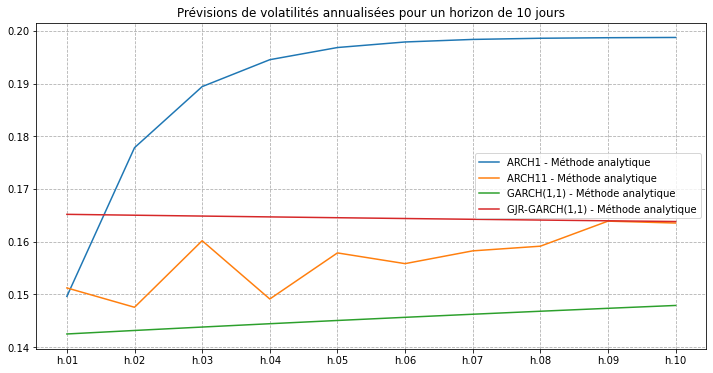

In [94]:
plt.figure(figsize=(12,6)) 
plt.plot(analytical_fcst_vol, label="ARCH1 - Méthode analytique")
plt.plot(analytical_fcst_arch11_vol, label="ARCH11 - Méthode analytique")
plt.plot(analytical_garch_fcst_vol, label="GARCH(1,1) - Méthode analytique")
plt.plot(cm_gjr_garch_fcst_vol, label="GJR-GARCH(1,1) - Méthode analytique")
plt.title(f"Prévisions de volatilités annualisées pour un horizon de {HORIZON} jours")
plt.legend()
plt.grid(linestyle="--")

***Il faut également avoir en tête que dans le cas présent nous avons utiliser une loi Normale pour nos modélisations. L'utilitsation d'une loi de Student devrait impacter les paramètres (sans remettre en cause les conclusions).***

Essayons pour notre dernier modèle !

In [102]:
gjr_cm_t_garch = arch_model(daily_returns*100, p=1, o=1, q=1, dist="StudentsT")
model_gjr_cm_t_garch = gjr_cm_t_garch.fit()
print(model_gjr_cm_t_garch.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 141066.68613813698
Iteration:      2,   Func. Count:     18,   Neg. LLF: 117536.43795491007
Iteration:      3,   Func. Count:     27,   Neg. LLF: 10669.709437171052
Iteration:      4,   Func. Count:     36,   Neg. LLF: 6697.46075456455
Iteration:      5,   Func. Count:     44,   Neg. LLF: 6692.055111426149
Iteration:      6,   Func. Count:     52,   Neg. LLF: 6677.938526541289
Iteration:      7,   Func. Count:     60,   Neg. LLF: 6754.422304838208
Iteration:      8,   Func. Count:     68,   Neg. LLF: 6600.189105216685
Iteration:      9,   Func. Count:     75,   Neg. LLF: 6610.537527409388
Iteration:     10,   Func. Count:     83,   Neg. LLF: 6599.870151705356
Iteration:     11,   Func. Count:     90,   Neg. LLF: 6599.847714575724
Iteration:     12,   Func. Count:     97,   Neg. LLF: 6599.847651749058
Iteration:     13,   Func. Count:    104,   Neg. LLF: 6599.847650714635
Iteration:     14,   Func. Count:    110,   Neg. LLF: 6599.847

In [111]:
student_gjr_garch_lt_vol = np.sqrt(model_gjr_cm_t_garch.params[1] / (1 - (model_gjr_cm_t_garch.params[2] + model_gjr_cm_t_garch.params[3]*0.5 + model_gjr_cm_t_garch.params[4])))*np.sqrt(252)
print(f"Volatilité de long terme : {student_gjr_garch_lt_vol/100:.2%}")

Volatilité de long terme : 17.14%


In [104]:
df_gjr_t_garch_vol = pd.DataFrame(model_gjr_cm_t_garch._volatility, index=daily_returns.index)*np.sqrt(252)

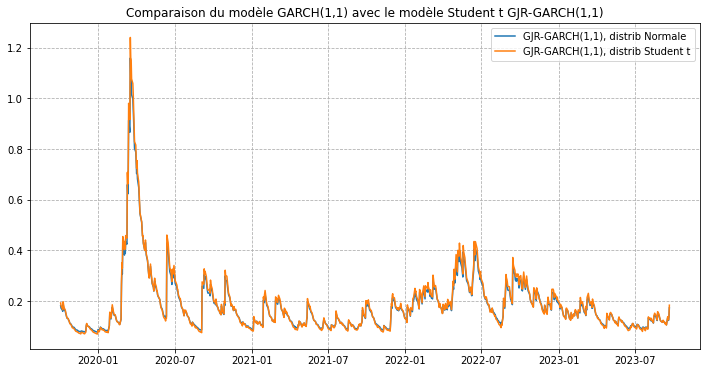

In [107]:
plt.figure(figsize=(12,6))
plt.plot(df_gjr_garch_vol.tail(1000)/100., label="GJR-GARCH(1,1), distrib Normale")
plt.plot(df_gjr_t_garch_vol.tail(1000)/100., label="GJR-GARCH(1,1), distrib Student t")
plt.legend()
plt.title("Comparaison du modèle GARCH(1,1) avec le modèle Student t GJR-GARCH(1,1)")
plt.grid(linestyle="--")

Sur un horizon de temps long, les différences sont à peine perceptible, c'est pourquoi je retrace les séries temporelles sur une période plus courte :

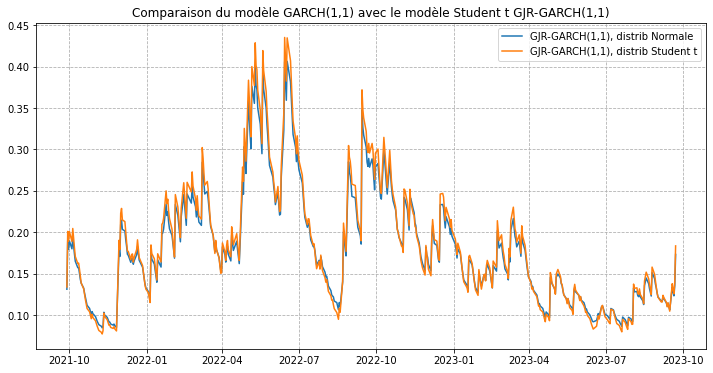

In [109]:
plt.figure(figsize=(12,6))
plt.plot(df_gjr_garch_vol.tail(500)/100., label="GJR-GARCH(1,1), distrib Normale")
plt.plot(df_gjr_t_garch_vol.tail(500)/100., label="GJR-GARCH(1,1), distrib Student t")
plt.legend()
plt.title("Comparaison du modèle GARCH(1,1) avec le modèle Student t GJR-GARCH(1,1)")
plt.grid(linestyle="--")

L'utilisation d'une distribution de student permet d'améliorer les résultats tout en gardant la cohérence des modélisations précédentes. Cependant, on observe que lors des phases de stress, la volatilité à tendance à monter plus haut qu'avec la modélisation en loi normale, ce qui est plus réaliste.

Tableau récapitulatif des résultats :

|        |&emsp;&emsp; ARCH(1) &emsp;&emsp;|&emsp;&emsp;ARCH(11)&emsp;&emsp;|&emsp;&emsp;GARCH(1,1)&emsp;&emsp;|&emsp;GJR-GARCH(1,1)|Student-t GJR-GARCH(1,1)|
|:-------|:-----------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| BIC       | 15 493     | 13 714      | 13 643        | 13 480            |13 251 |
    | LT Vol| 19.88%     | 17.74%      | 17.07%        | 15.80%            |  17.14%  |
| $\mu$     | 0.0742     | 0.0718      | 0.0692        | 0.0322            |  0.0551  |
| $\alpha$  | 0.4607     | -           | 0.1243        | 0.0089            | 0   |
| $\beta$   | -          | -           | 0.8542        | 0.8777            |  0.8736  |
| $\omega$  | 0.8456     | 0.1949      | 0.0249        | 0.0236            |  0.0191  |
| $\gamma$  | -          | -           | -             | 0.1793            | 0.22   |

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">
&#x1F4A1;
Ces résultats nous rappellent que la volatilité est un concept complexe et subjectif, qui nécessite une compréhension approfondie des différentes approches de modélisation. Il est crucial de reconnaître qu'il n'existe pas une seule mesure absolue de la volatilité réelle, tant les différences méthologiques peuvent conduire à des estimations différentes pour un même actif financier à un moment donné.
</p>

<u><b><a id='multivariate_model'>III. Modélisation multivariée</a></b></u>

1. <a id='ccc_model'>Constant Conditional Correlations (CCC)</a>

_Work in progress_

2. <a id='dcc_model'>Dynamic Conditional Correlations (DCC)</a>

_Work in progress_